In [216]:
import pyscamp
from obspy import read, UTCDateTime, Stream
import os
import numpy as np
import sys
import time
from glob import glob
from functions import *

wf_dir = "/home/gilbert_lab/cami_frs/borehole_data/sac_daily_nez_500Hz/"

def get_stream(station, channel, starttime, endtime, fs):
    print("Getting data stream for station %s, channel %s..." % (station, channel))
    
    day = starttime.strftime("%Y%m%d")
    path_search = os.path.join(wf_dir, day, "BH.%s..%s*" % (station, channel))
    file_list = glob(path_search)
    st = Stream()
    if len(file_list) > 0:
        for file in file_list:
            print("Reading file %s" % file)
            tmp = read(file, starttime=starttime, endtime=endtime)    
            if len(tmp) > 1:
                raise ValueError("More than one trace read from file, that's weird...")
            if tmp[0].stats.sampling_rate != fs:
                tmp.resample(fs)
            st.append(tmp[0])
    else:
        print("No data found for day %s" % day)
        print("\t\tSearch string was: %s" % path_search)
    
    # Fill gaps with noise
    st = fill_time_gaps_noise(st)
    
    # Convert to nm/s
    trace = st[0]    
    trace.data *= 1e17 #1e9        
    
    print("\tFinal Stream:")
    print("\tSampling rate: %f" % fs)
    print("\tStart time: %s" % trace.stats.starttime.strftime("%Y-%m-%d %H:%M:%S"))
    print("\tEnd time: %s" % trace.stats.endtime.strftime("%Y-%m-%d %H:%M:%S"))
    
    return trace


In [30]:
wf_dir = "/home/gilbert_lab/cami_frs/borehole_data/sac_daily_500Hz/"
starttime = UTCDateTime(2020, 2, 18, 0, 0, 0)
endtime = UTCDateTime(2020, 2, 19, 0, 0, 0)

def get_mp(data, sublen_samp):
    proc_start = time.time()
    mp, mpind = pyscamp.selfjoin(data, sublen_samp, gpus=[0, 1, 2, 3], pearson=True, precision="double")
    proc_end = time.time()
    print("Finished processing component in %f seconds" % (proc_end - proc_start))
    return mp, mpind

fs = 250.0
print(fs)

# Define window
sublen_sec = 0.5
sublen_samp = int(0.5 * fs)
trace1 = get_stream(station="G12", channel="DP1", starttime=starttime, endtime=endtime, fs=fs)
mp1, mpind1 = get_mp(data=trace1.data, sublen_samp=sublen_samp)

sublen_samp = int(0.5 * fs)
trace2 = get_stream(station="G12", channel="DP2", starttime=starttime, endtime=endtime, fs=fs)
mp2, mpind2 = get_mp(data=trace2.data, sublen_samp=sublen_samp)

sublen_samp = int(0.5 * fs)
trace3 = get_stream(station="G12", channel="DP3", starttime=starttime, endtime=endtime, fs=fs)
mp3, mpind3 = get_mp(data=trace3.data, sublen_samp=sublen_samp)

# Save time array
# t = trace1.times("matplotlib")

# Get stack
stack = (mp1 + mp2 + mp3)/3

250.0
Getting data stream for station G12, channel DP3...
Reading file /home/gilbert_lab/cami_frs/borehole_data/sac_daily_500Hz/20200218/BH.G12..DP3.20200218000000_20200219000000_500Hz_unitmps.sac
	Final Stream:
	Sampling rate: 250.000000
	Start time: 2020-02-18 00:00:00
	End time: 2020-02-18 23:59:59
Finished processing component in 1950.664306 seconds


In [34]:
# sublen_samp = int(5.0 * fs)
# mp1, mpind1 = get_mp(data=trace1.data, sublen_samp=sublen_samp)
print(mp1.shape)
print(mp2.shape)
print(mp3.shape)
print("trace 1: min = %e, max = %e" % (np.min(np.abs(trace1.data)), np.max(np.abs(trace1.data))))
print("trace 2: min = %e, max = %e" % (np.min(np.abs(trace2.data)), np.max(np.abs(trace2.data))))
print("trace 3: min = %e, max = %e" % (np.min(np.abs(trace3.data)), np.max(np.abs(trace3.data))))

from statsmodels.robust import mad
print("MAD for MP1: %e " % mad(mp1))
print("MAD for MP2: %e " % mad(mp2))
print("MAD for MP3: %e " % mad(mp3))

(21599876,)
(21599876,)
(21599876,)
trace 1: min = 6.126241e-09, max = 4.259607e+01
trace 2: min = 1.336720e-08, max = 3.320999e+01
trace 3: min = 8.487548e-01, max = 7.864946e+09
MAD for MP1: 2.363004e-02 
MAD for MP2: 2.454843e-02 
MAD for MP3: 2.564514e-02 


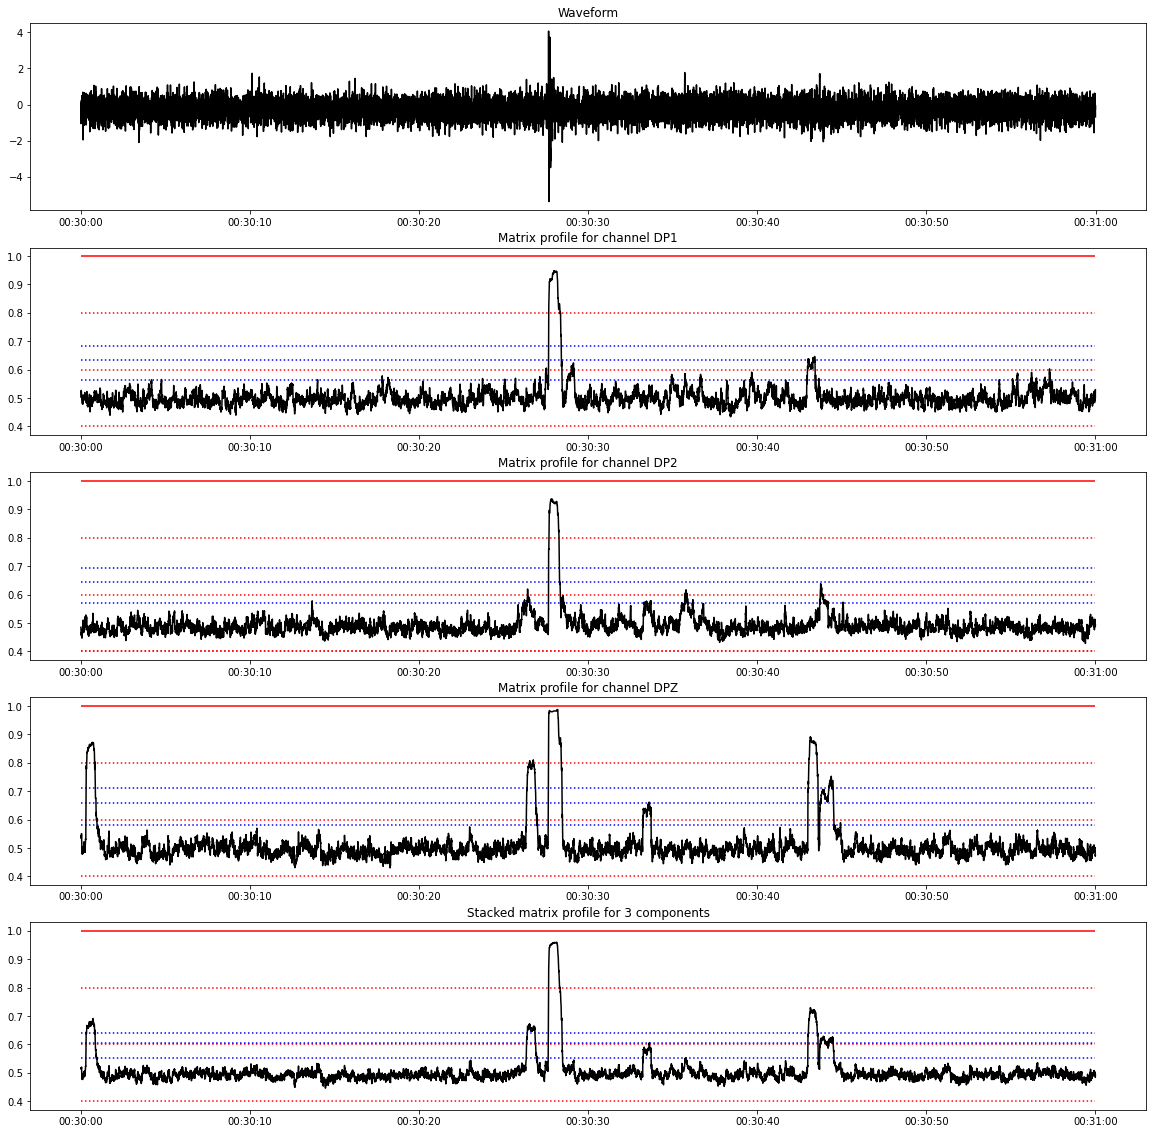

In [40]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

#datac = trace2.data[sublen_samp-1:]
#tc = t[sublen_samp-1:]
stack = (mp1 + mp2 + mp3 + mp3)/4

# Window for plotting
# t1 = tc[0]
# t2 = tc[-1]
t1 = mdates.date2num(UTCDateTime(2020, 2, 18, 0, 30, 0).datetime)
t2 = mdates.date2num(UTCDateTime(2020, 2, 18, 0, 31, 0).datetime)
_, idx1 = find_nearest(tc, t1)
_, idx2 = find_nearest(tc, t2)

fig, axs = plt.subplots(5,1, figsize=(20,20))
axs[0].plot_date(tc[idx1:idx2], datac[idx1:idx2], "k")
axs[0].set_title("Waveform")
axs[1].plot_date(tc[idx1:idx2], mp1[idx1:idx2], "k")
axs[1].set_title("Matrix profile for channel DP1")
axs[2].plot_date(tc[idx1:idx2], mp2[idx1:idx2], "k")
axs[2].set_title("Matrix profile for channel DP2")
axs[2].hlines(0.4, xmin=tc[idx1], xmax=tc[idx2], linestyle=":", color="r")
axs[3].plot_date(tc[idx1:idx2], mp3[idx1:idx2], "k")
axs[3].set_title("Matrix profile for channel DPZ")
ax.hlines(0.4, xmin=tc[idx1], xmax=tc[idx2], linestyle=":", color="r")
axs[4].plot_date(tc[idx1:idx2], stack[idx1:idx2], "k")
axs[4].set_title("Stacked matrix profile for 3 components")
for ax in [axs[1], axs[2], axs[3], axs[4]]:
    ax.hlines(0.4, xmin=tc[idx1], xmax=tc[idx2], linestyle=":", color="r")
    ax.hlines(0.6, xmin=tc[idx1], xmax=tc[idx2], linestyle=":", color="r")
    ax.hlines(0.8, xmin=tc[idx1], xmax=tc[idx2], linestyle=":", color="r")
    ax.hlines(1.0, xmin=tc[idx1], xmax=tc[idx2], linestyle="-", color="r")
for ax, mp in zip([axs[1], axs[2], axs[3], axs[4]], [mp1, mp2, mp3, stack]):
    ax.hlines(np.median(mp) + 3*mad(mp), xmin=tc[idx1], xmax=tc[idx2], linestyle=":", color="b")
    ax.hlines(np.median(mp) + 6*mad(mp), xmin=tc[idx1], xmax=tc[idx2], linestyle=":", color="b")
    ax.hlines(np.median(mp) + 8*mad(mp), xmin=tc[idx1], xmax=tc[idx2], linestyle=":", color="b")
# axs[0].set_xlim([t1, t2])
# axs[1].set_xlim([t1, t2])
# axs[2].set_xlim([t1, t2])

sublen_samp = 125
0.5*sublen_samp = 62
Time = 2020-02-18T00:30:00.708000Z
	Peak height 0.691286
	Prominence = 0.214540
	Width = 139.415230
	Width (s) = 0.557661
	Matching windows for:
		690751: t = 2020-02-18T00:46:03.500000Z
		13826698: t = 2020-02-18T15:21:47.288000Z
		865562: t = 2020-02-18T00:57:42.744000Z


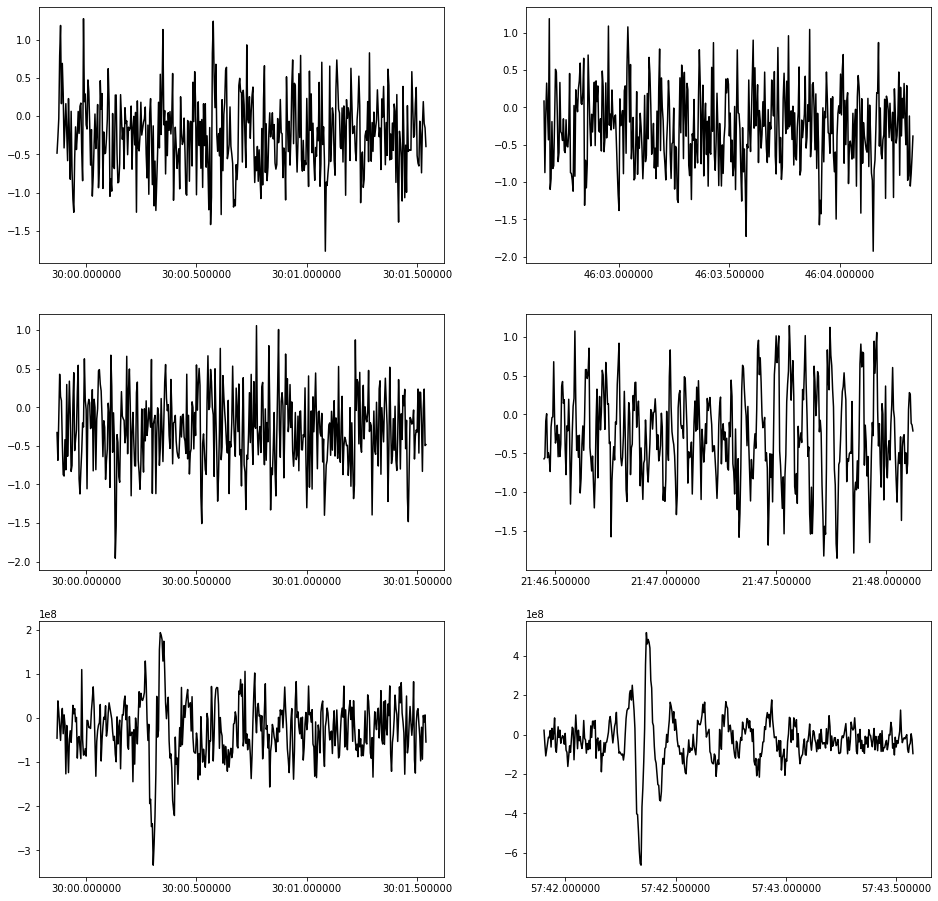

Time = 2020-02-18T00:30:26.524000Z
	Peak height 0.672545
	Prominence = 0.202651
	Width = 139.633775
	Width (s) = 0.558535
	Matching windows for:
		361034: t = 2020-02-18T00:24:04.632000Z
		9968882: t = 2020-02-18T11:04:36.024000Z
		11773604: t = 2020-02-18T13:04:54.912000Z


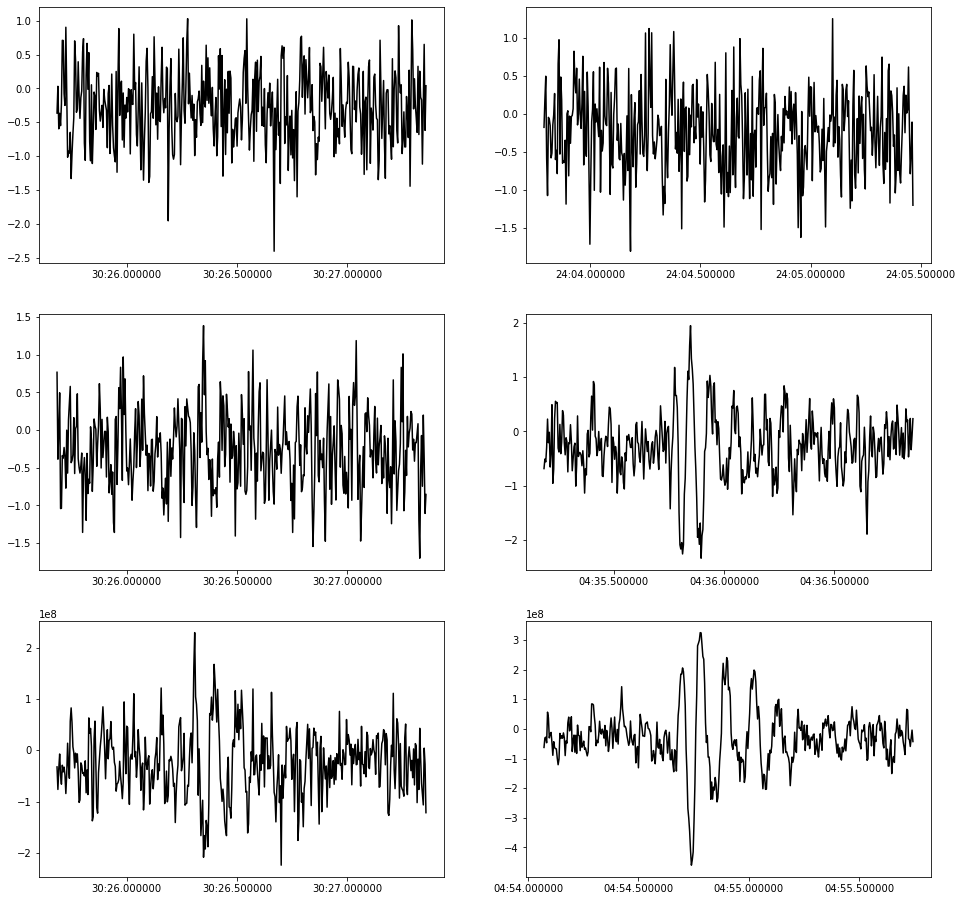

Time = 2020-02-18T00:30:28.124000Z
	Peak height 0.959881
	Prominence = 0.507520
	Width = 188.777158
	Width (s) = 0.755109
	Matching windows for:
		7467034: t = 2020-02-18T08:17:48.632000Z
		7467034: t = 2020-02-18T08:17:48.632000Z
		7467034: t = 2020-02-18T08:17:48.632000Z


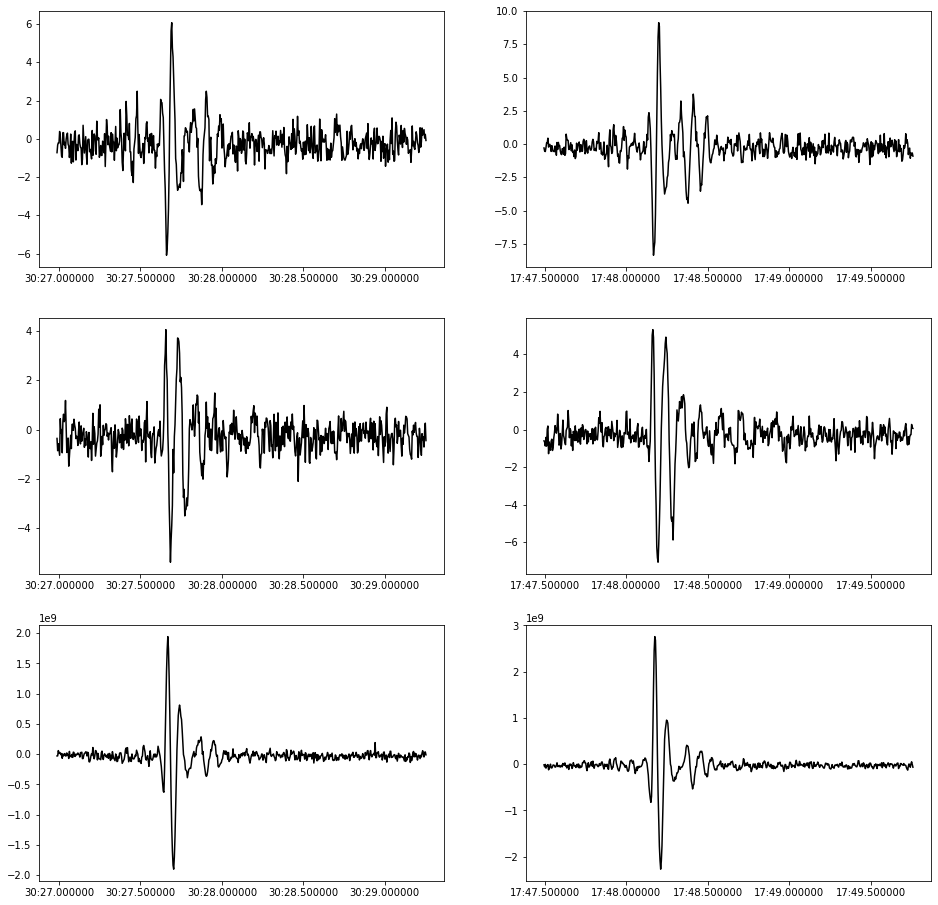

Time = 2020-02-18T00:30:33.612000Z
	Peak height 0.605376
	Prominence = 0.144852
	Width = 124.814508
	Width (s) = 0.499258
	Matching windows for:
		286393: t = 2020-02-18T00:19:06.068000Z
		342436: t = 2020-02-18T00:22:50.240000Z
		10536080: t = 2020-02-18T11:42:24.816000Z


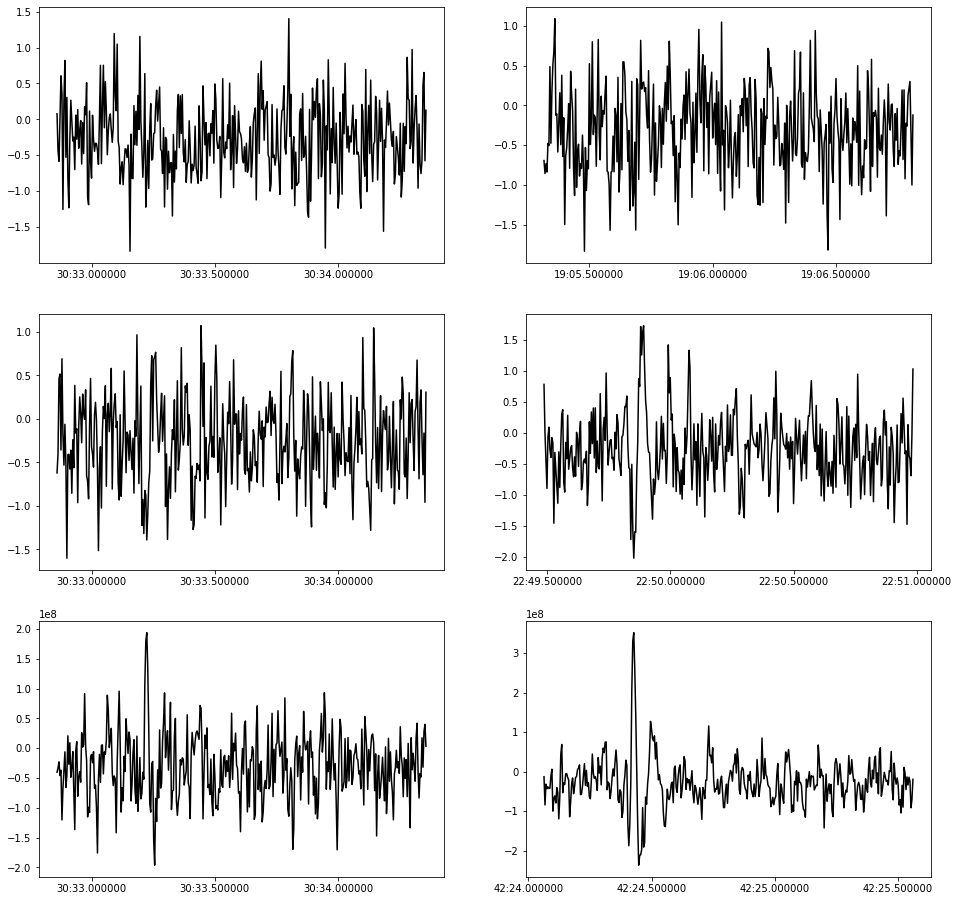

Time = 2020-02-18T00:30:43.140000Z
	Peak height 0.729503
	Prominence = 0.274512
	Width = 151.498877
	Width (s) = 0.605996
	Matching windows for:
		13330579: t = 2020-02-18T14:48:42.812000Z
		9410169: t = 2020-02-18T10:27:21.172000Z
		9184731: t = 2020-02-18T10:12:19.420000Z


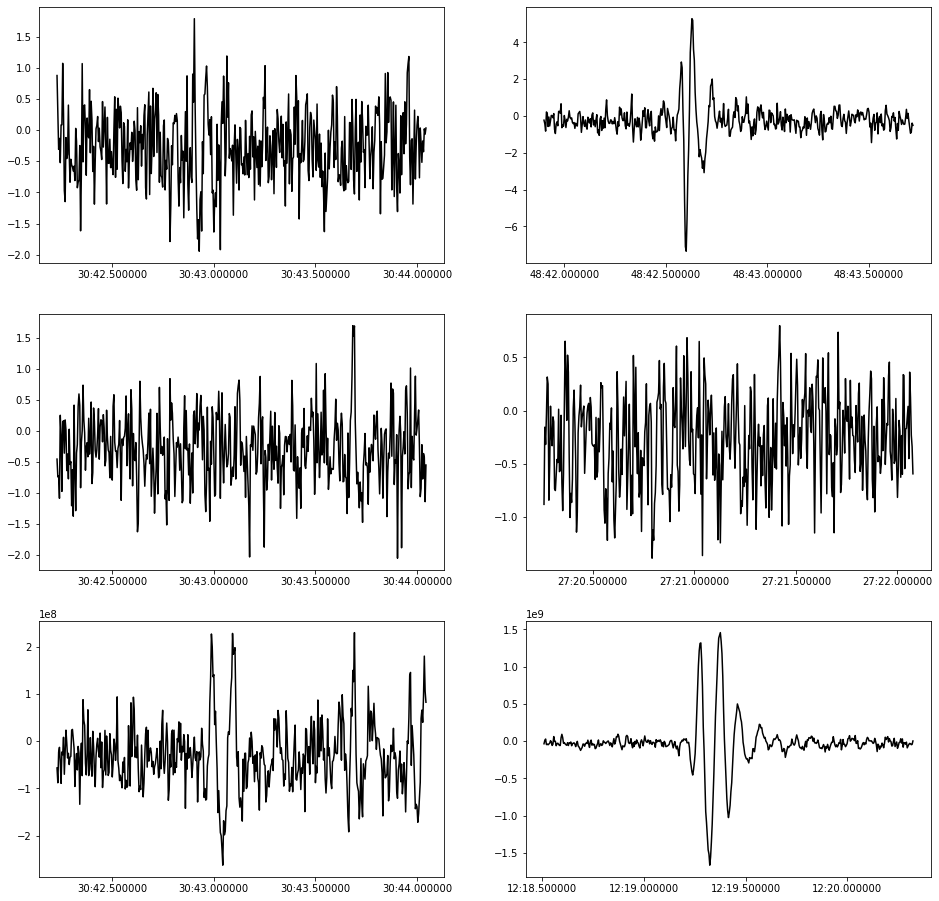

Time = 2020-02-18T00:30:43.908000Z
	Peak height 0.629019
	Prominence = 0.116673
	Width = 209.879999
	Width (s) = 0.839520
	Matching windows for:
		226986: t = 2020-02-18T00:15:08.440000Z
		503989: t = 2020-02-18T00:33:36.452000Z
		3257952: t = 2020-02-18T03:37:12.304000Z


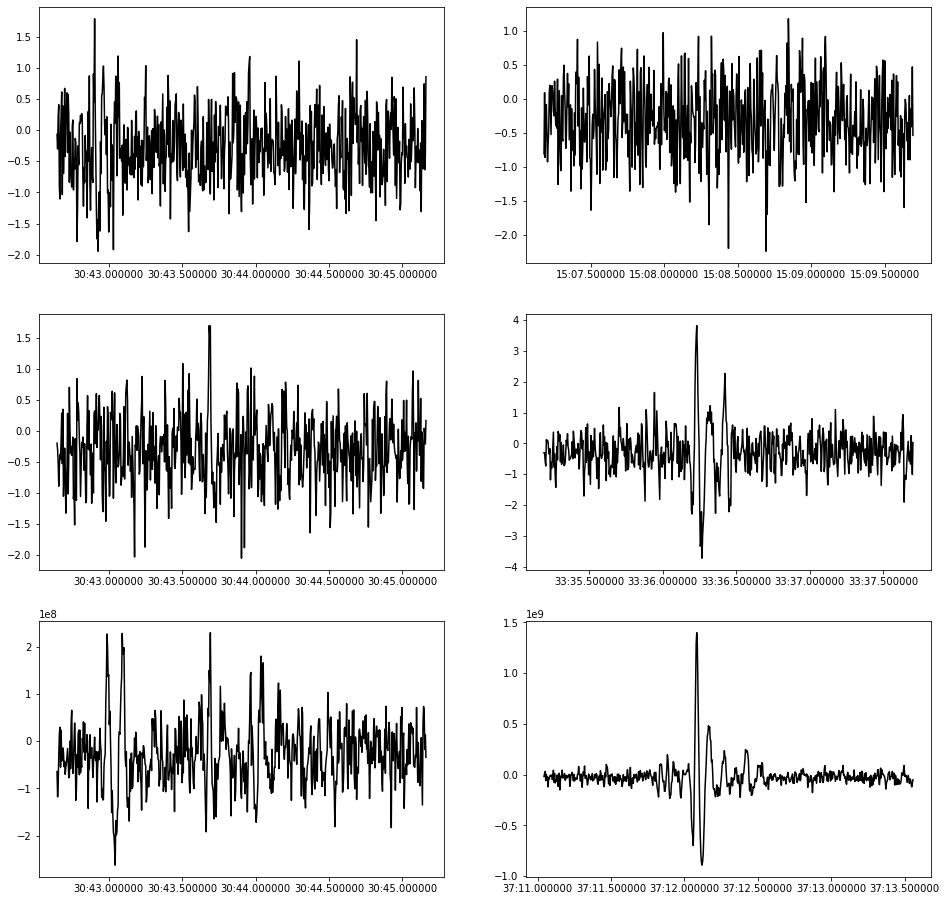

In [65]:
from scipy.signal import find_peaks

data1c = trace1.data[sublen_samp-1:]
data2c = trace2.data[sublen_samp-1:]
data3c = trace3.data[sublen_samp-1:]

mp = stack[idx1:idx2]
t = tc[idx1:idx2]
ind1 = mpind1[idx1:idx2]
ind2 = mpind2[idx1:idx2]
ind3 = mpind3[idx1:idx2]

lowthresh = np.median(mp) + 6*mad(mp)
height = (lowthresh, 1)
sublen_samp = int(0.5 * fs)
print("sublen_samp = %d" % sublen_samp)
print("0.5*sublen_samp = %d" % int(0.5*sublen_samp))

peaks, properties = find_peaks(mp, height=lowthresh,  width=int(0.5*sublen_samp)) #, prominence=0.3)
for idx in range(0,len(peaks)):
    dind = peaks[idx]
    tdet = UTCDateTime(mdates.num2date(t[dind]))
    print("Time = %s" % tdet)
    print("\tPeak height %f" % properties["peak_heights"][idx])
    print("\tProminence = %f" % properties["prominences"][idx])
    print("\tWidth = %f" % properties["widths"][idx])
    detw = properties["widths"][idx]/fs
    print("\tWidth (s) = %f" % detw)
    detws = properties["widths"][idx]
    
    i1 = int(idx1 + dind - 1.5*detws)
    i2 = int(idx1 + dind + 1.5*detws)
    
    print("\tMatching windows for:")
    fig, axs = plt.subplots(3, 2, figsize=(16,16))
    axs[0][0].plot_date(tc[i1:i2], data1c[i1:i2], "k")
    axs[1][0].plot_date(tc[i1:i2], data2c[i1:i2], "k")
    axs[2][0].plot_date(tc[i1:i2], data3c[i1:i2], "k")
    
    for i, ind, data in zip(range(3), [ind1, ind2, ind3], [data1c, data2c, data3c]):
        ix = ind[dind] 
        print("\t\t%d: t = %s" % (ix, UTCDateTime(mdates.num2date(tc[ix]))))
        j1 = int(ix-1.5*detws)
        j2 = int(ix+1.5*detws)
        axs[i][1].plot_date(tc[j1:j2], data[j1:j2], "k")
        
    plt.show()
    plt.close()
    

In [245]:
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
from obspy import UTCDateTime, read
import time
from statsmodels.robust import mad
from scipy.signal import find_peaks


wf_dir = "/home/gilbert_lab/cami_frs/borehole_data/sac_daily_nez_500Hz/"

def get_stream(station, channel, starttime, endtime, fs):
    print("Getting data stream for station %s, channel %s..." % (station, channel))
    
    day = starttime.strftime("%Y%m%d")
    path_search = os.path.join(wf_dir, day, "BH.%s..%s*" % (station, channel))
    file_list = glob(path_search)
    st = Stream()
    if len(file_list) > 0:
        for file in file_list:
            print("Reading file %s" % file)
            tmp = read(file, starttime=starttime, endtime=endtime)    
            if len(tmp) > 1:
                raise ValueError("More than one trace read from file, that's weird...")
            if tmp[0].stats.sampling_rate != fs:
                tmp.resample(fs)
            st.append(tmp[0])
    else:
        print("No data found for day %s" % day)
        print("\t\tSearch string was: %s" % path_search)
    
    # Fill gaps with noise
    st = fill_time_gaps_noise(st)
    
    # Convert to nm/s
    trace = st[0]    
    trace.data *= 1e17 #1e9        
    
    print("\tFinal Stream:")
    print("\tSampling rate: %f" % fs)
    print("\tStart time: %s" % trace.stats.starttime.strftime("%Y-%m-%d %H:%M:%S"))
    print("\tEnd time: %s" % trace.stats.endtime.strftime("%Y-%m-%d %H:%M:%S"))
    
    return trace

def merge_intervals(intervals):
    """
    A simple algorithm can be used:
    1. Sort the intervals in increasing order
    2. Push the first interval on the stack
    3. Iterate through intervals and for each one compare current interval
       with the top of the stack and:
       A. If current interval does not overlap, push on to stack
       B. If current interval does overlap, merge both intervals in to one
          and push on to stack
    4. At the end return stack
    https://codereview.stackexchange.com/questions/69242/merging-overlapping-intervals
    """
    sorted_by_lower_bound = sorted(intervals, key=lambda tup: tup[0])
    merged = []

    for higher in sorted_by_lower_bound:
        if not merged:
            merged.append(higher)
        else:
            lower = merged[-1]
            # test for intersection between lower and higher:
            # we know via sorting that lower[0] <= higher[0]
            if higher[0] <= lower[1]:
                upper_bound = max(lower[1], higher[1])
                merged[-1] = np.array([lower[0], upper_bound])  # replace by merged interval
            else:
                merged.append(higher)
    return np.array(merged)

def idx_to_windows(indices1, indices2):
    """
    """
    indices = np.hstack((indices1, indices2))

    # Find unique intervals for all window pairs
    x = indices - int(sublen_samp/2)
    y = indices + int(sublen_samp/2)
    intervals = np.array((x,y)).T
    windows = merge_intervals(intervals)
    
    return windows

def associate_ids(merged_windows, indices1, indices2):
    """
    Associate windows to each index for each pair
    return: Pandas DataFrame
    https://stackoverflow.com/questions/44367672/best-way-to-join-merge-by-range-in-pandas
    """
    # Setup for pandas
    lb = merged_windows[:, 0] # Lower bound of windows
    ub = merged_windows[:, 1] # upper bound of windows
    dfref = pd.DataFrame({"lower_bound": lb,
                          "upper_bound": ub,
                          "window_id": range(len(lb))})
    pairs = pd.DataFrame({"Index1": indices1, "Index2": indices2})
    

    # Find window id for first indices of pairs
    i, j = np.where((indices1[:, None] >= lb) & (indices1[:, None] <= ub))

    df = pd.DataFrame(
        np.column_stack([pairs.iloc[i], dfref.iloc[j]]), 
        columns=pd.Index(data=["Index1", "Index2", "lb1", "ub1", "win_id_1"]) #df1.columns.append(dfref.columns)
    )

    # Find window id for second indices of pairs
    i, j = np.where((indices2[:, None] >= lb) & (indices2[:, None] <= ub))

    dfw = pd.DataFrame(
        np.column_stack([df.iloc[i], dfref.iloc[j]]), 
        columns=df.columns.append(pd.Index(data=["lb2", "ub2", "win_id_2"])) #df1.columns.append(dfref.columns)
    )

    return dfw, dfref

# Input
fname_mp = "matrix_profiles/20200310000000.000000_20200310235959.996000_G12_DPZ_250Hz_win125samp_mp.npy"
fname_ind = "matrix_profiles/20200310000000.000000_20200310235959.996000_G12_DPZ_250Hz_win125samp_mp.npy"
#mp = np.load("matrix_profiles/20200310000000.000000_20200310235959.996000_G12_DPZ_250Hz_win125samp_mp.npy")
#ind = np.load("matrix_profiles/20200310000000.000000_20200310235959.996000_G12_DPZ_250Hz_win125samp_ind.npy")
station = os.path.split(fname_mp)[1].split("_")[2]
channel = os.path.split(fname_mp)[1].split("_")[3]
print("Station %s, channel %s" % (station, channel))
starttime = UTCDateTime(os.path.split(fname_mp)[1].split("_")[0])
endtime = UTCDateTime(os.path.split(fname_mp)[1].split("_")[1])
fs = float(os.path.split(fname_mp)[1].split("_")[4].split("Hz")[0])
print("Start time %s" % starttime)
print("End time %s" % endtime)
print("Sampling rate: %s" % fs)

sublen_samp = int(os.path.split(fname_mp)[1].split("_")[5].split("win")[1].split("samp")[0])
print("sublen_samp = %d" % sublen_samp)
print("Length of MP: %d samples" % mp.shape[0])

# Get seismogram
trace = get_stream(station=station, channel=channel, starttime=starttime, endtime=endtime, fs=fs)
datac = trace.data[sublen_samp-1:]

# Get peaks in MP
lowthresh = np.median(mp) + 5*mad(mp)
procs = time.time()
peaks, properties = find_peaks(mp, height=lowthresh,  width=int(0.5*sublen_samp)) #, prominence=0.3)
proce = time.time()
print("Time for find_peaks: %f s." % (proce - procs))
print("# peaks: %d" % len(peaks))

# Get index pairs corresponding to peaks and associate to unique windows
indices1 = peaks.astype(int)
indices2 = np.take(ind, indices1).astype(int)
merged_windows = idx_to_windows(indices1, indices2)
df, dfref = associate_ids(merged_windows, indices1, indices2)


Station G12, channel DPZ
Start time 2020-03-10T00:00:00.000000Z
End time 2020-03-10T23:59:59.996000Z
Sampling rate: 250.0
sublen_samp = 125
Length of MP: 21599876 samples
Getting data stream for station G12, channel DPZ...
Reading file /home/gilbert_lab/cami_frs/borehole_data/sac_daily_nez_500Hz/20200310/BH.G12..DPZ.20200310000000_500Hz_unitmps.sac
	Final Stream:
	Sampling rate: 250.000000
	Start time: 2020-03-10 00:00:00
	End time: 2020-03-10 23:59:59
Time for find_peaks: 2.349969 s.
# peaks: 3023


In [190]:
class Graph:
    """ 
    Class to find connected components of an undirected graph using DFS algorithm
    Example:
    Create a graph given in the above diagram, 5 vertices numbered from 0 to 4

    g = Graph(5)
    g.addEdge(1, 0)
    g.addEdge(2, 3)
    g.addEdge(3, 4)
    cc = g.connectedComponents()
    print("Following are connected components")
    print(cc)
    https://www.geeksforgeeks.org/connected-components-in-an-undirected-graph/
    """
    
    # init function to declare class variables
    def __init__(self, V):
        self.V = V
        self.adj = [[] for i in range(V)]

    def DFSUtil(self, temp, v, visited):

        # Mark the current vertex as visited
        visited[v] = True

        # Store the vertex to list
        temp.append(v)

        # Repeat for all vertices adjacent
        # to this vertex v
        for i in self.adj[v]:
            if visited[i] == False:

                # Update the list
                temp = self.DFSUtil(temp, i, visited)
        return temp

    # method to add an undirected edge
    def addEdge(self, v, w):
        self.adj[v].append(w)
        self.adj[w].append(v)

    # Method to retrieve connected components
    # in an undirected graph
    def connectedComponents(self):
        visited = []
        cc = []
        for i in range(self.V):
            visited.append(False)
        for v in range(self.V):
            if visited[v] == False:
                temp = []
                cc.append(self.DFSUtil(temp, v, visited))
        return cc



Building the graph...
2862
Getting connected components...
Time to get connected components: 0.002393 s.
2020-03-10T00:00:00.500000Z
2687
16


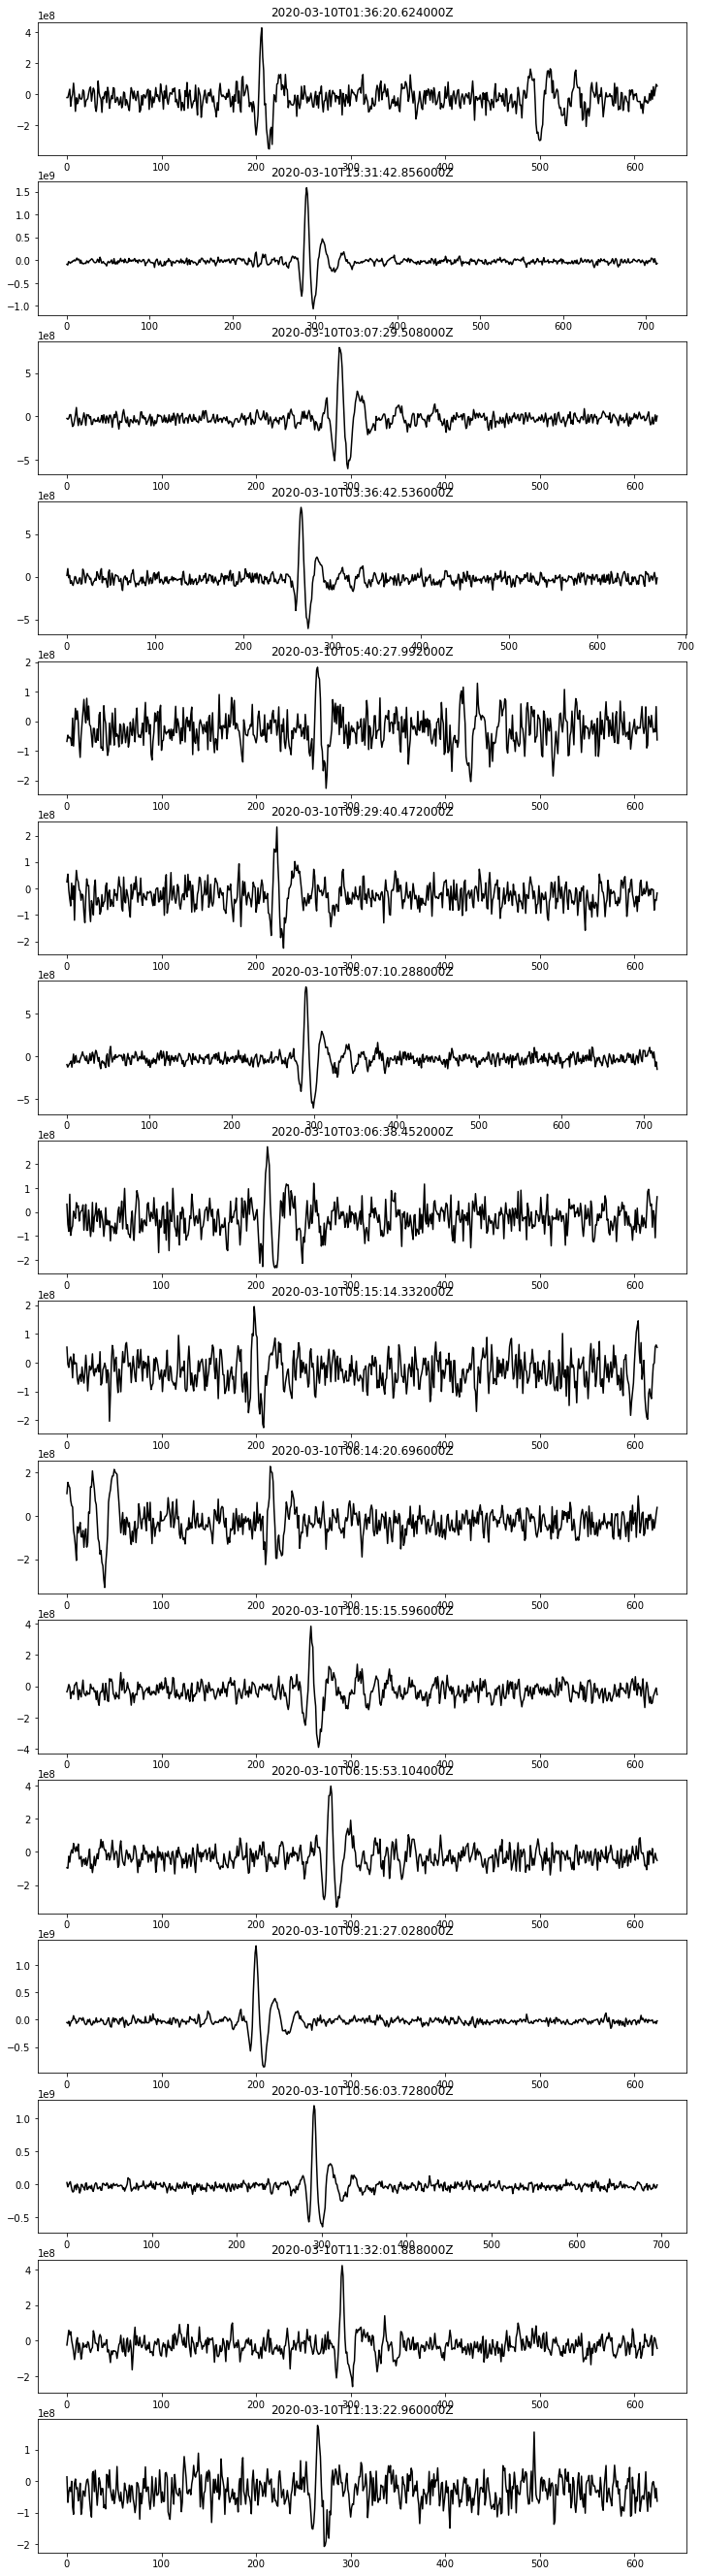

****************************************************************************************************
15


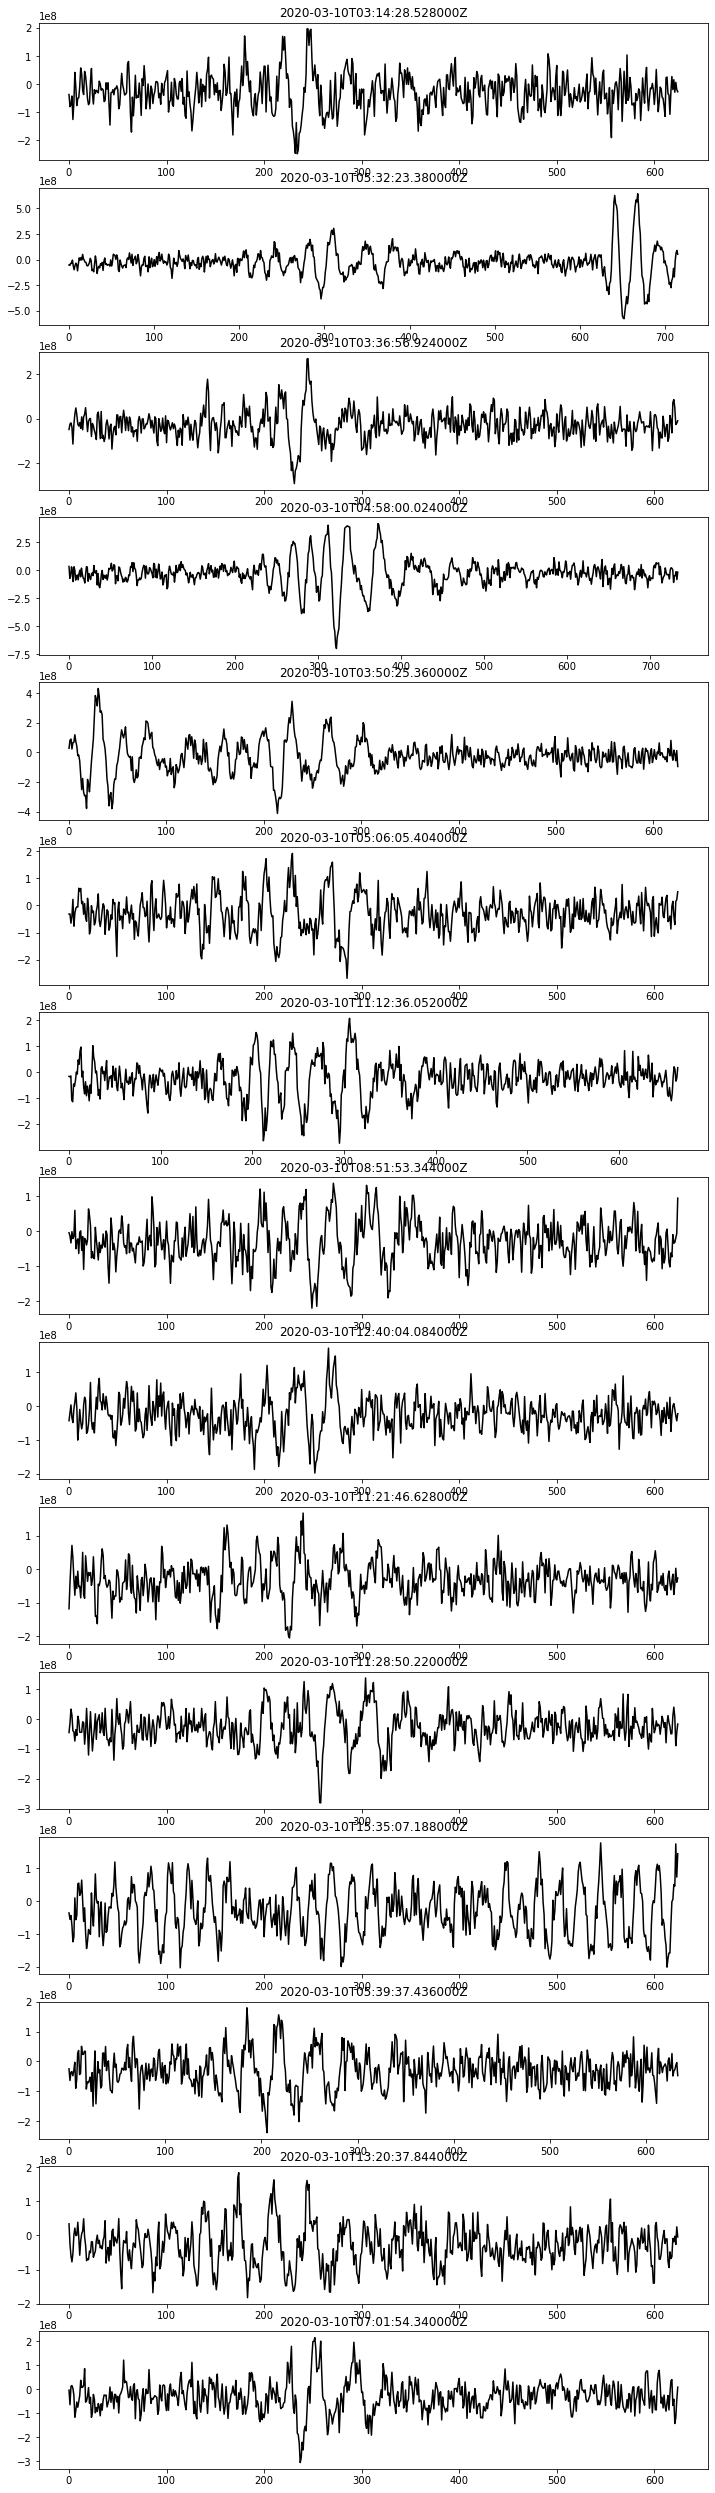

****************************************************************************************************
11


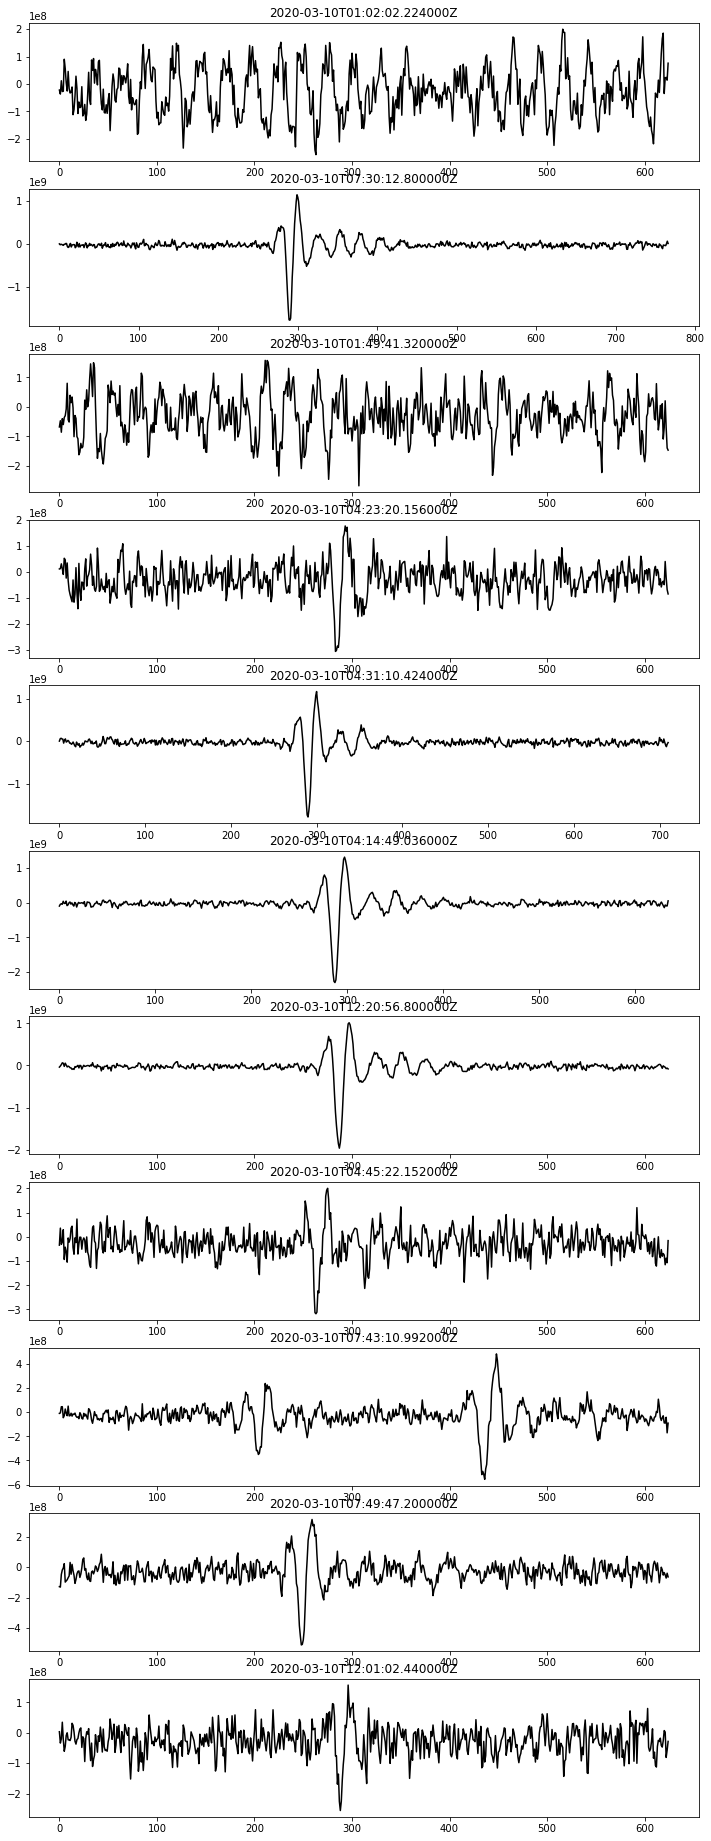

****************************************************************************************************
10


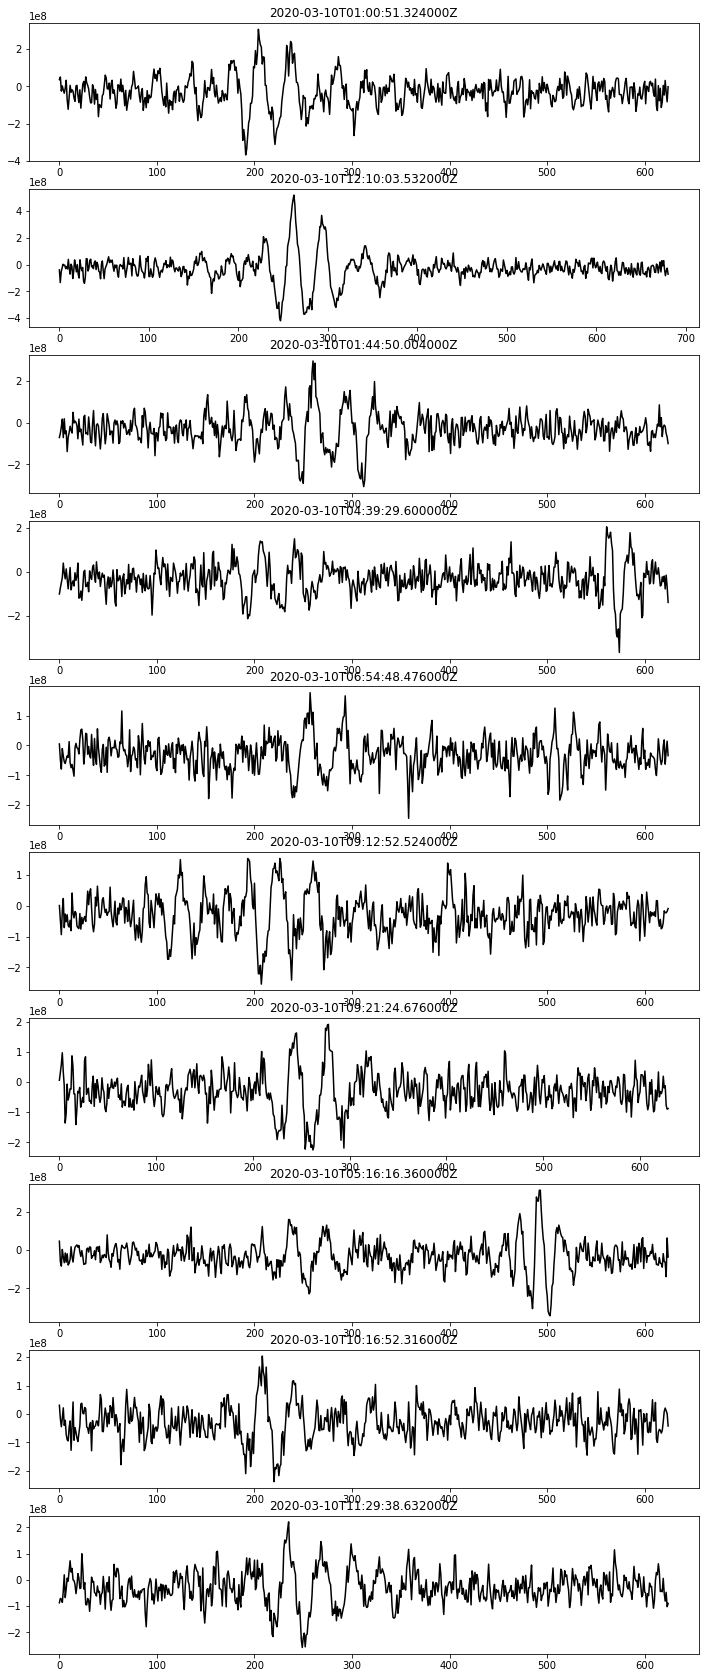

****************************************************************************************************
10


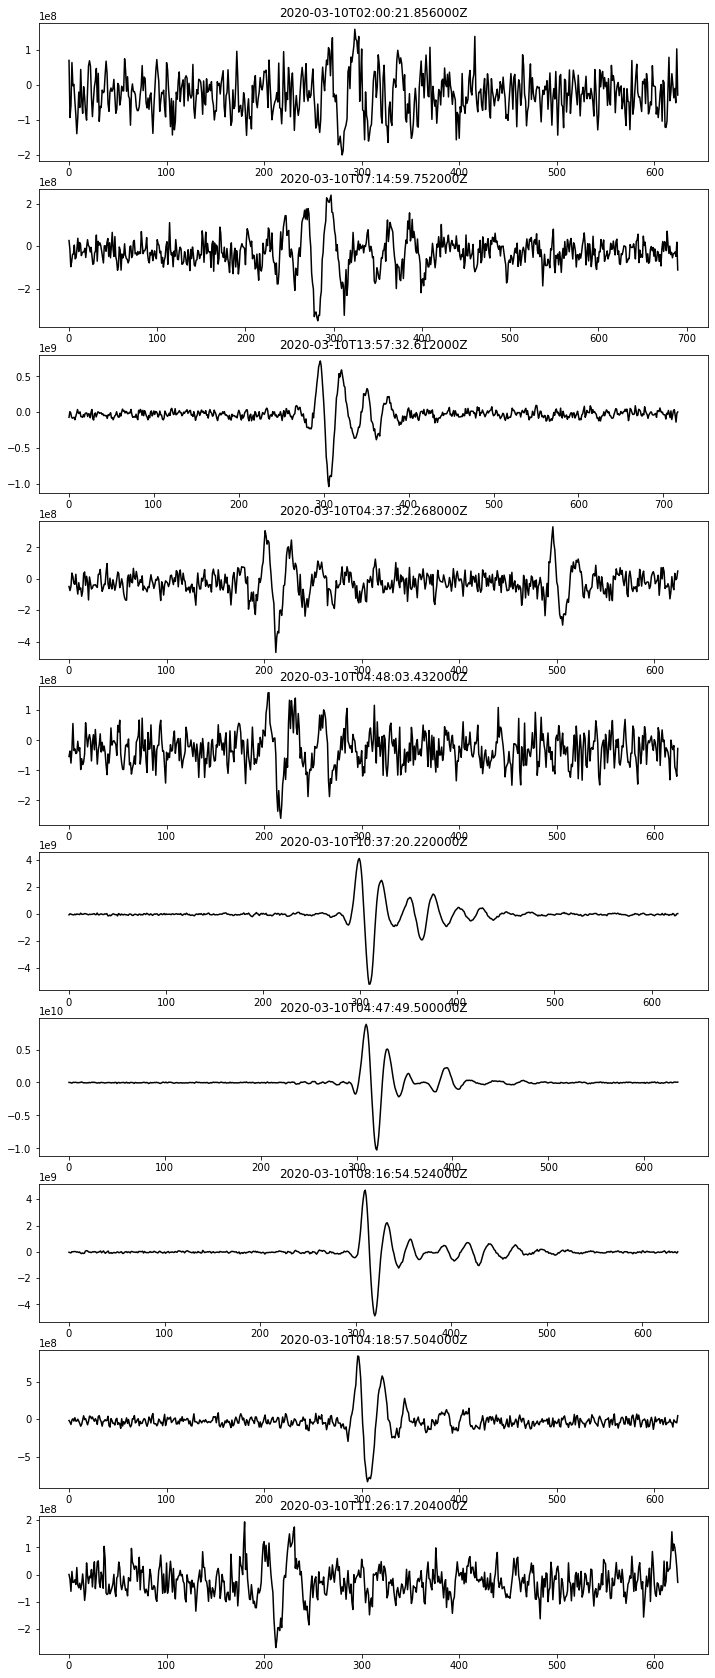

****************************************************************************************************
9


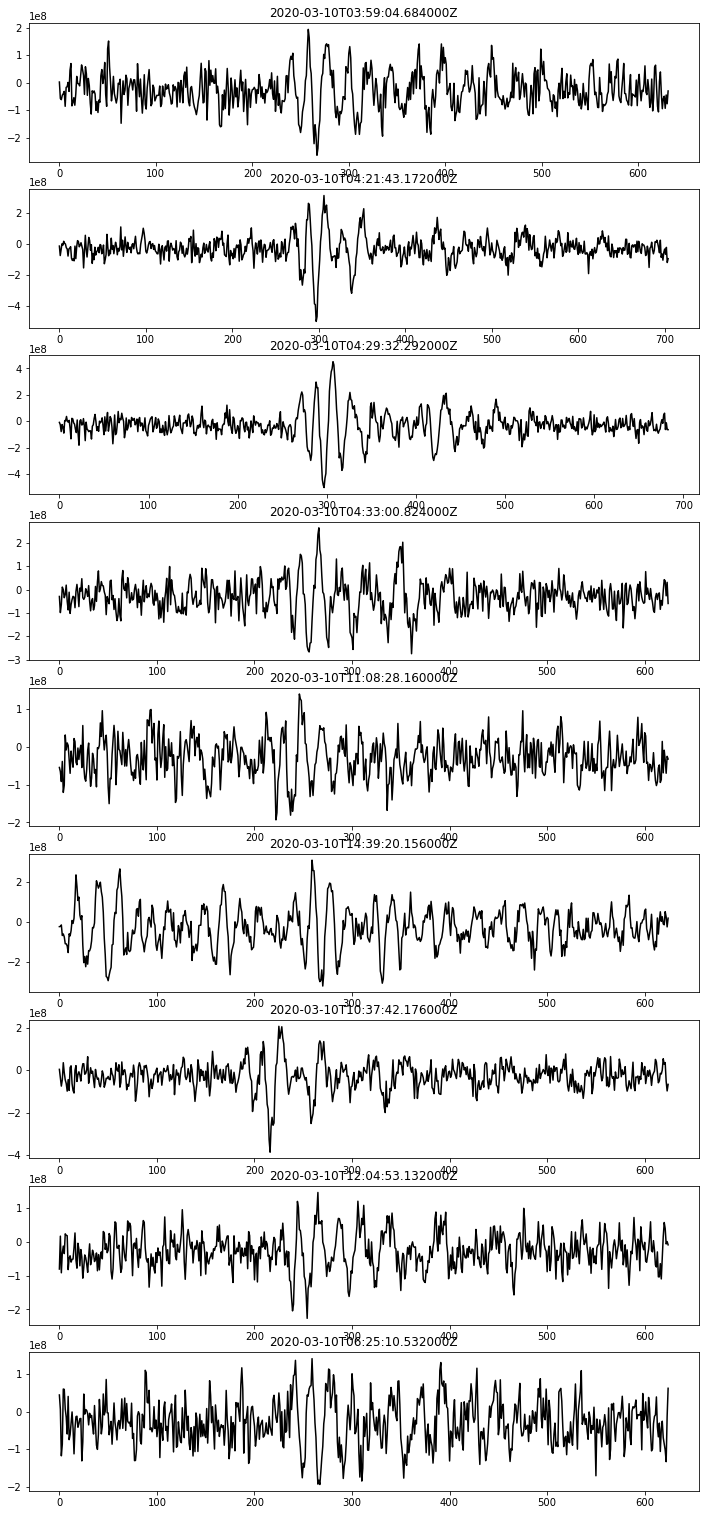

****************************************************************************************************
8


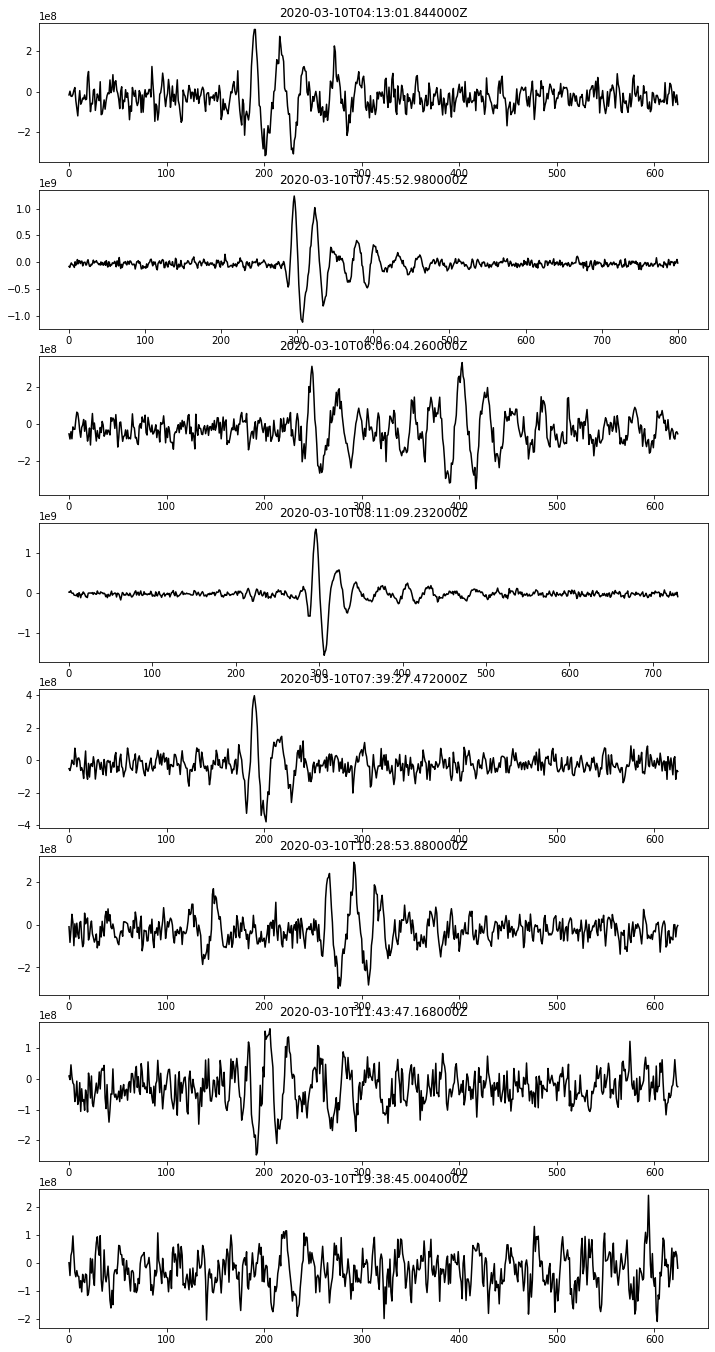

****************************************************************************************************
5


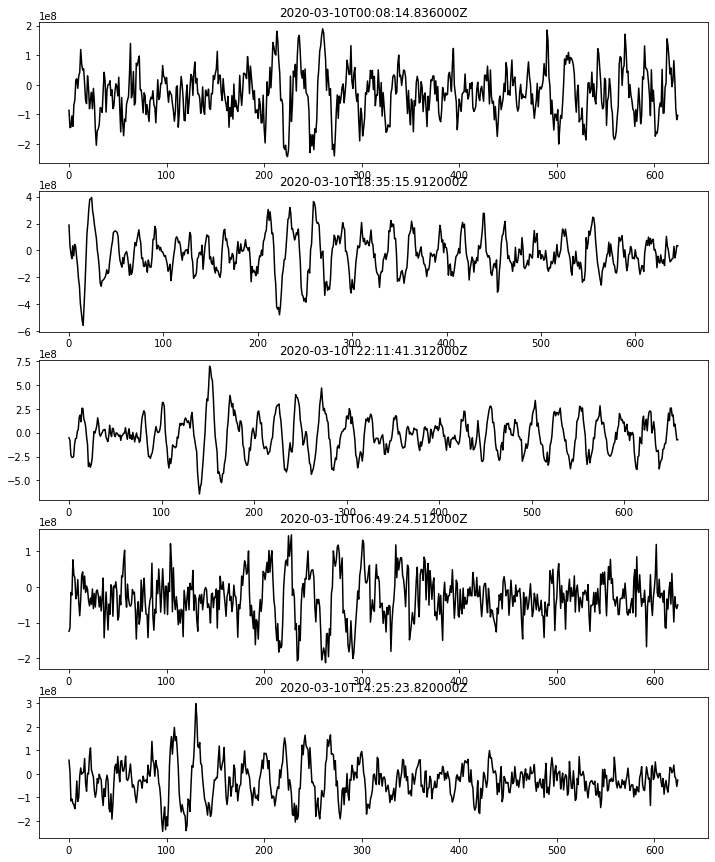

****************************************************************************************************
5


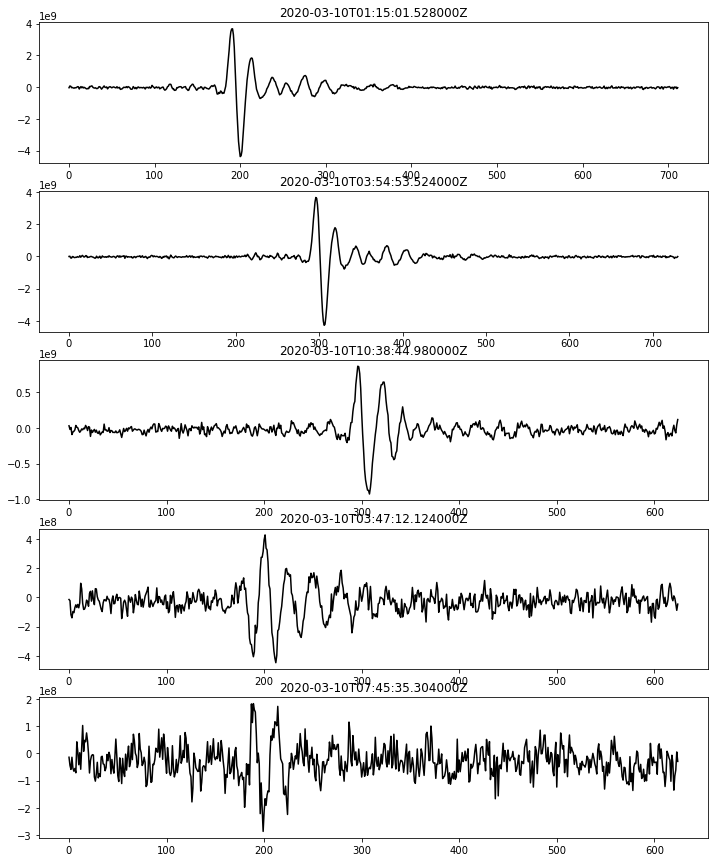

****************************************************************************************************
5


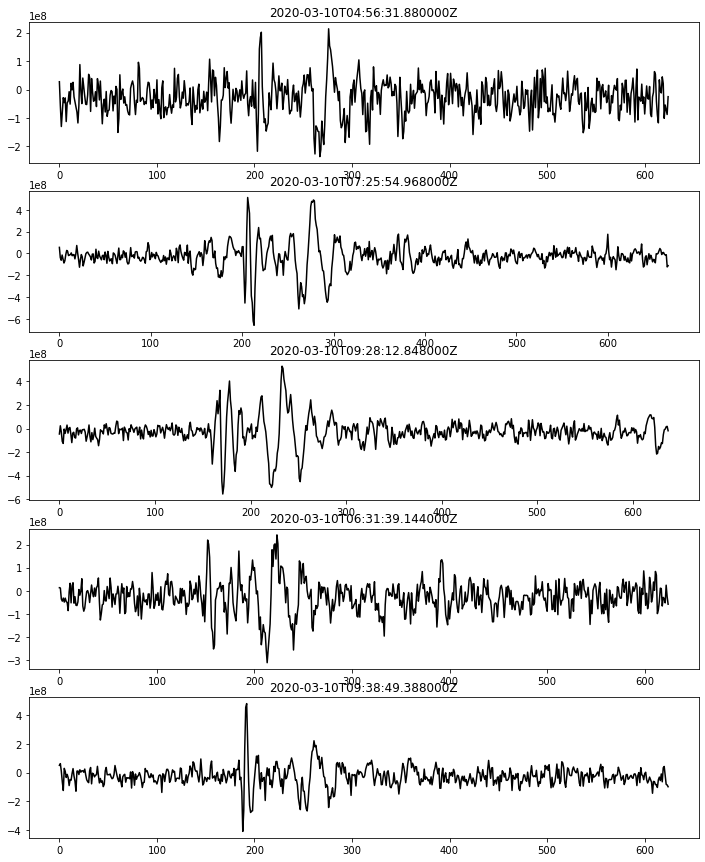

****************************************************************************************************
5


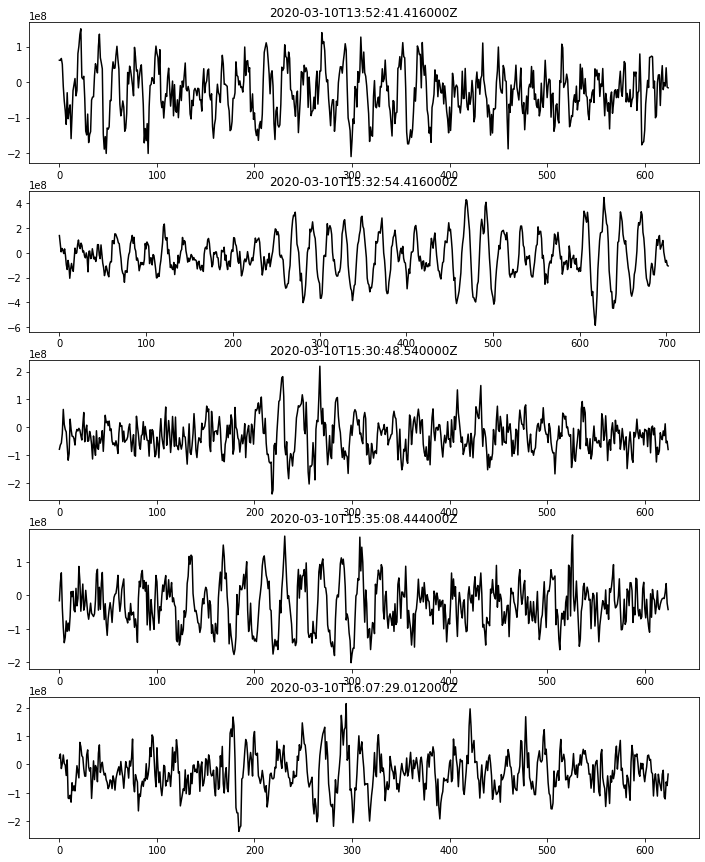

****************************************************************************************************
4


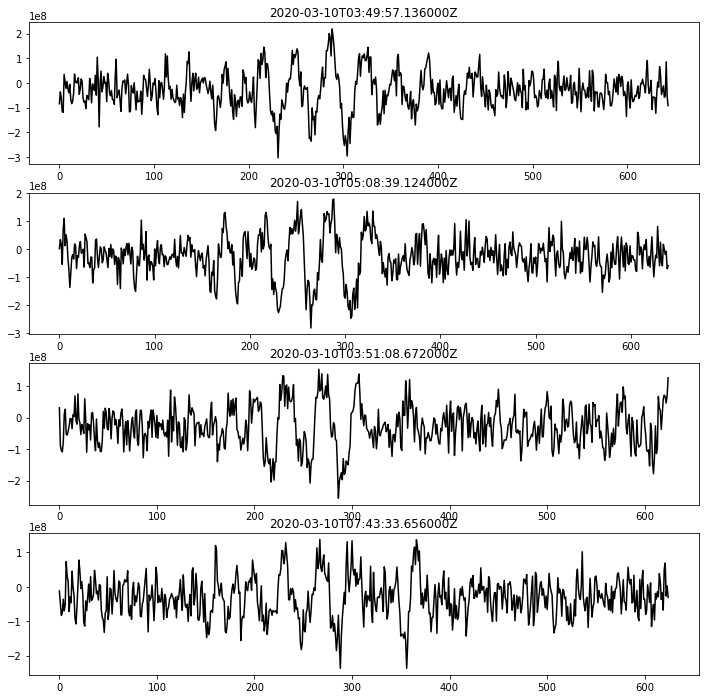

****************************************************************************************************
4


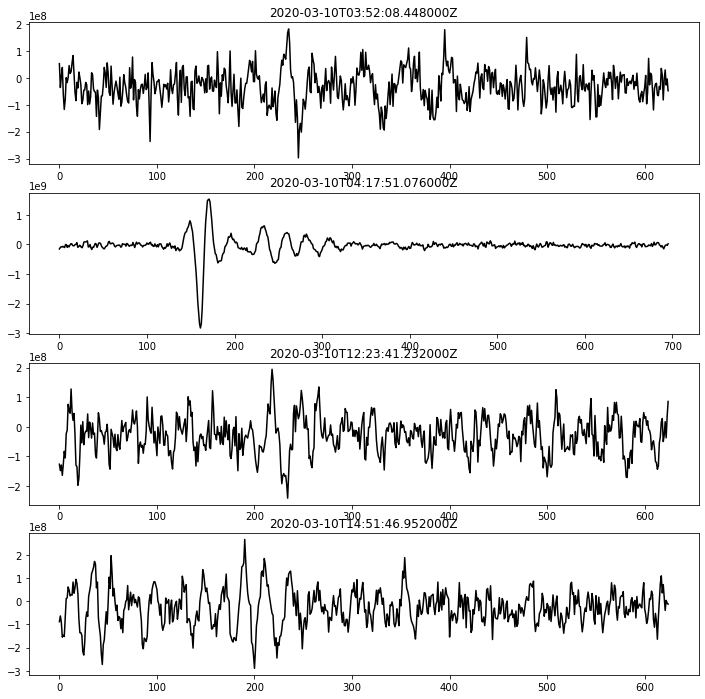

****************************************************************************************************
4


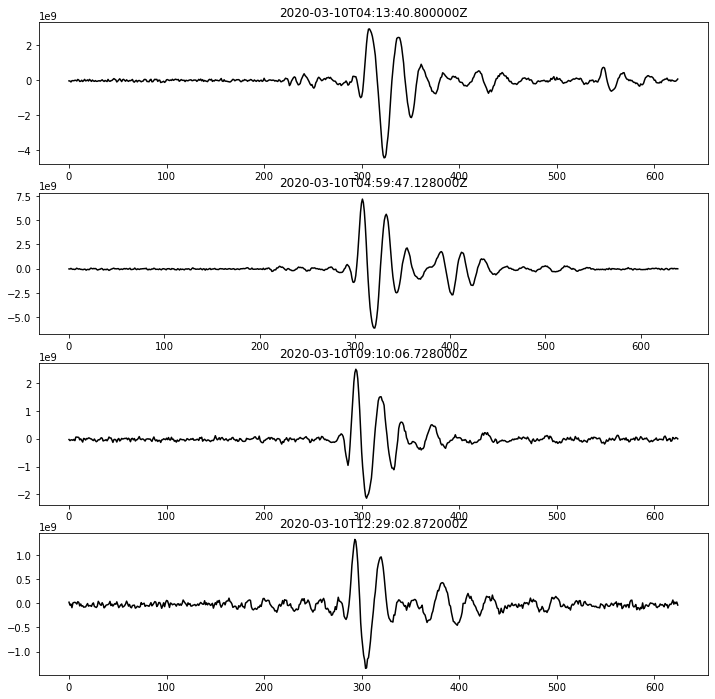

****************************************************************************************************
4


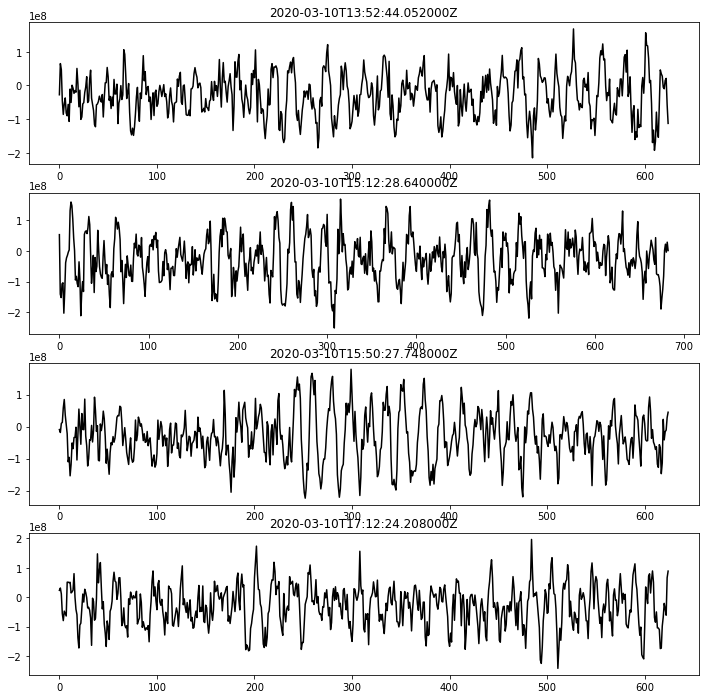

****************************************************************************************************
4


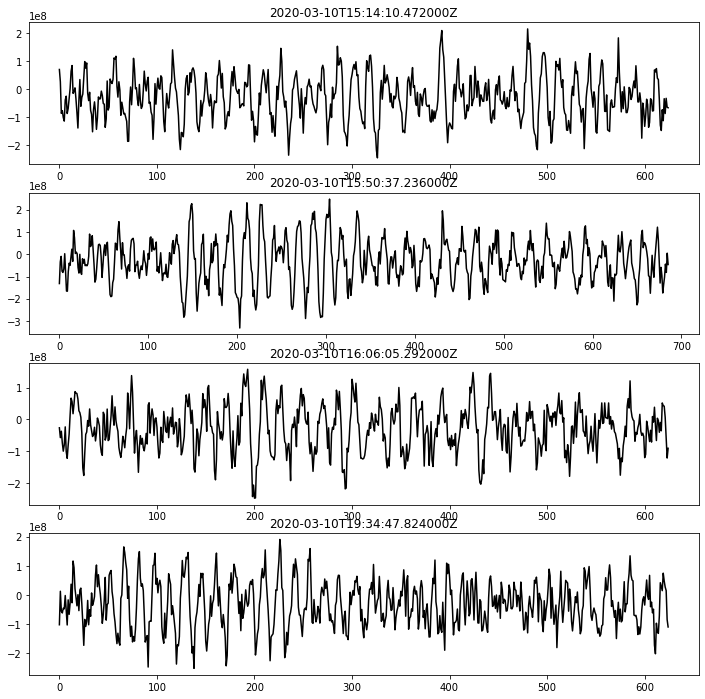

****************************************************************************************************
3


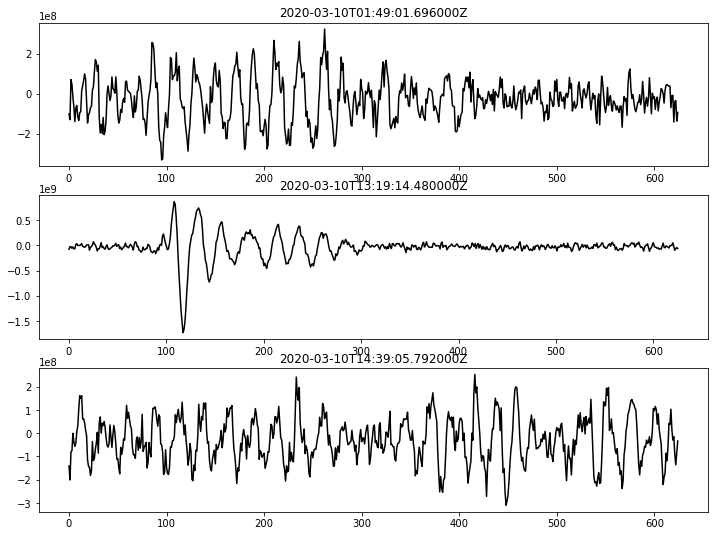

****************************************************************************************************
3


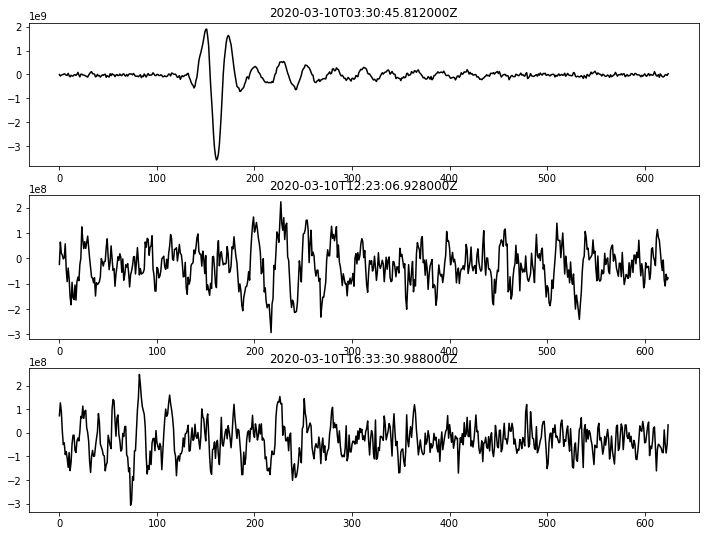

****************************************************************************************************
3


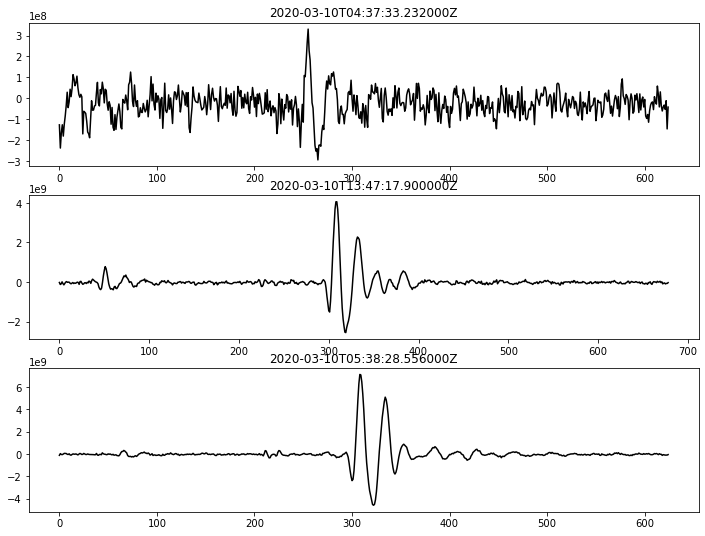

****************************************************************************************************
3


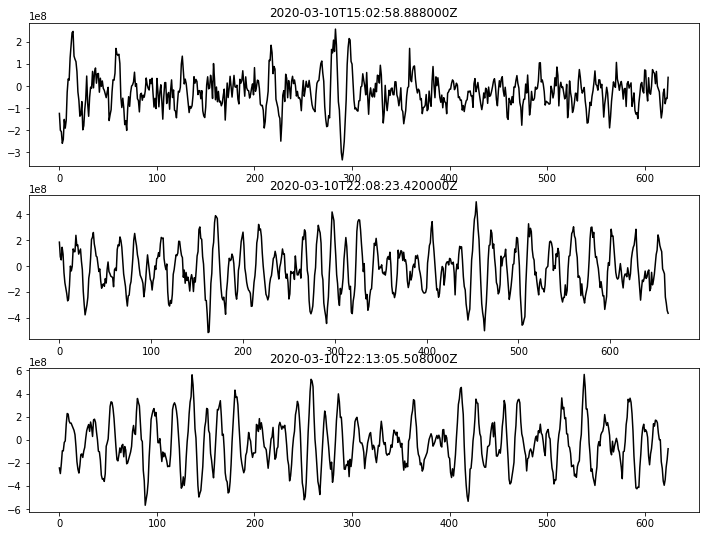

****************************************************************************************************
2


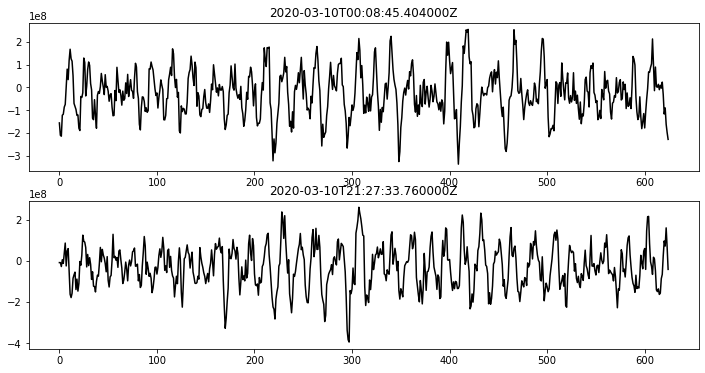

****************************************************************************************************
2


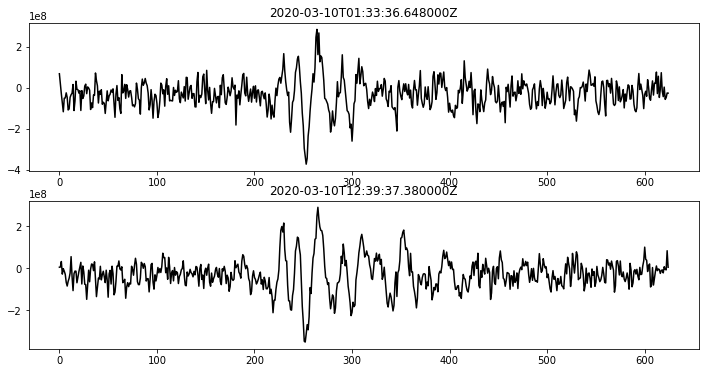

****************************************************************************************************
2


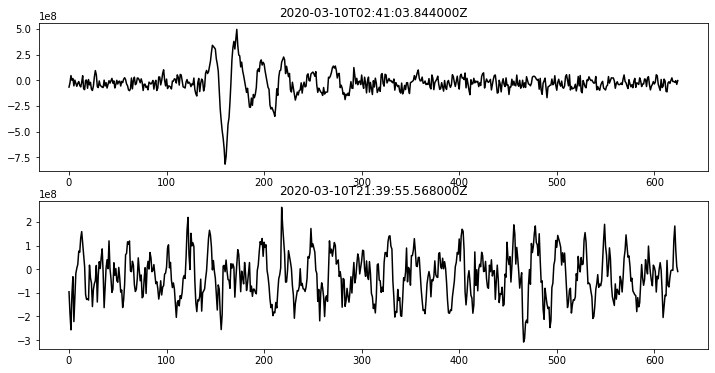

****************************************************************************************************
2


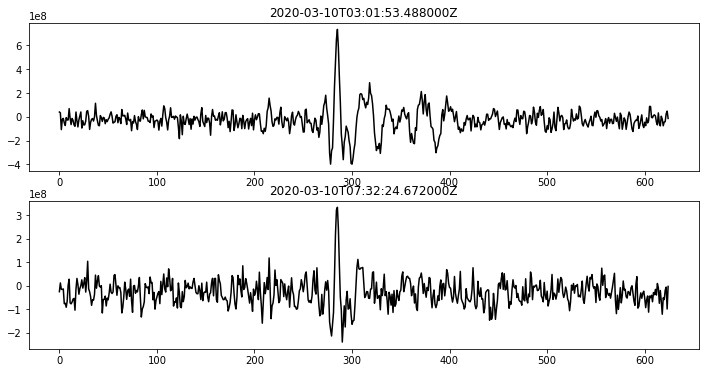

****************************************************************************************************
2


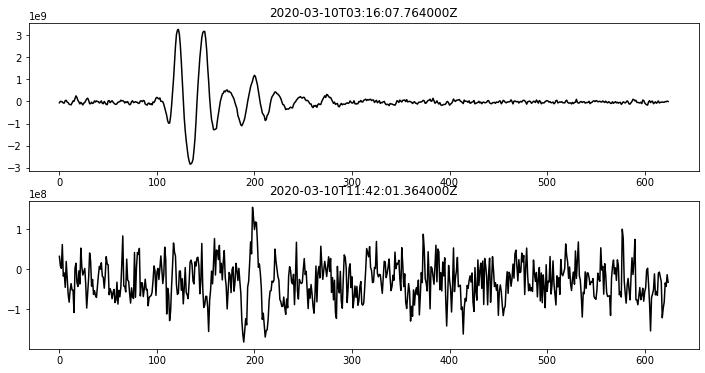

****************************************************************************************************
2


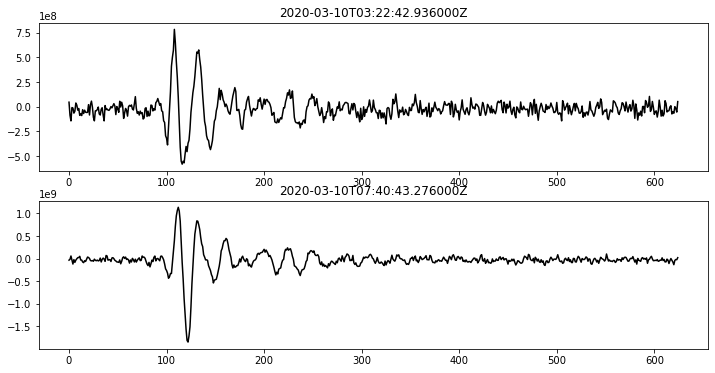

****************************************************************************************************
2


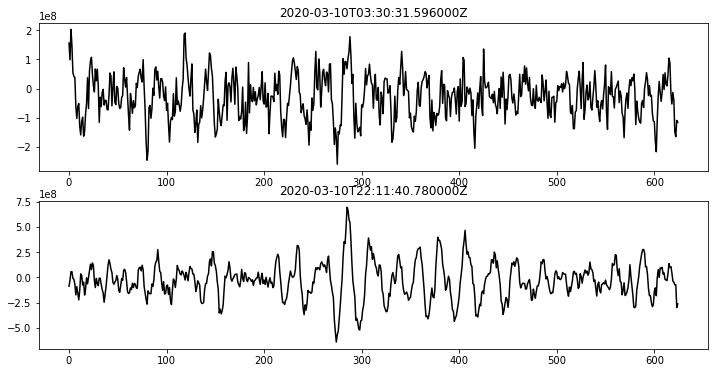

****************************************************************************************************
2


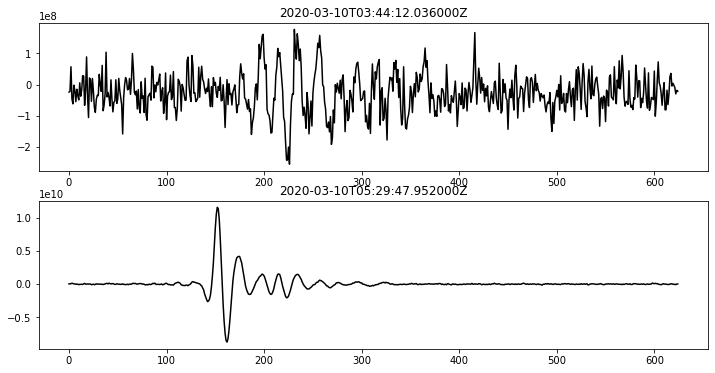

****************************************************************************************************
2


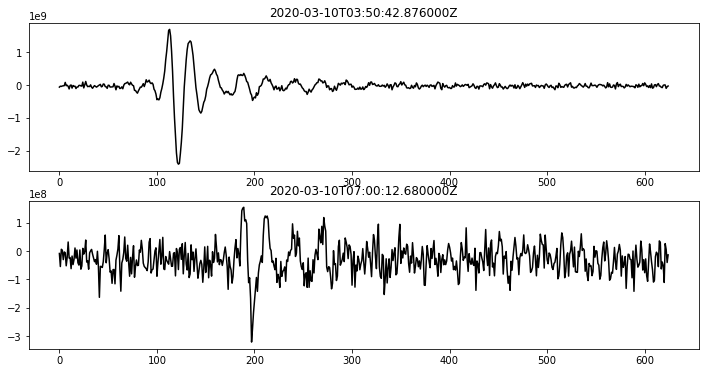

****************************************************************************************************
2


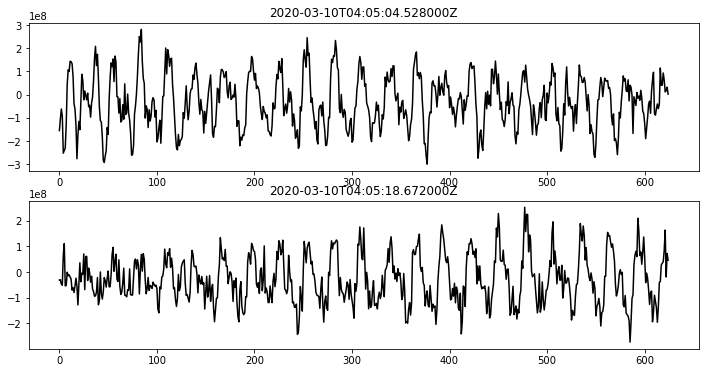

****************************************************************************************************
2


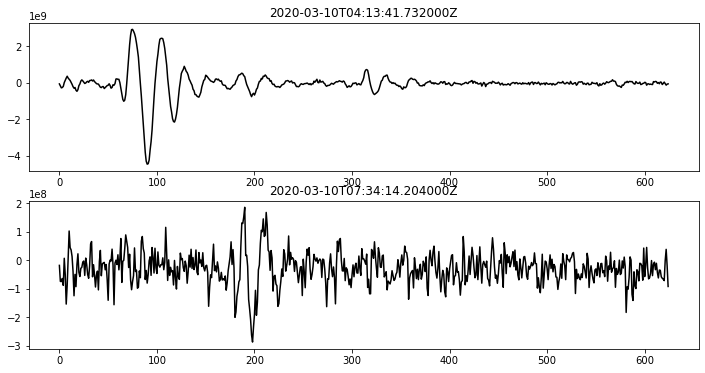

****************************************************************************************************
2


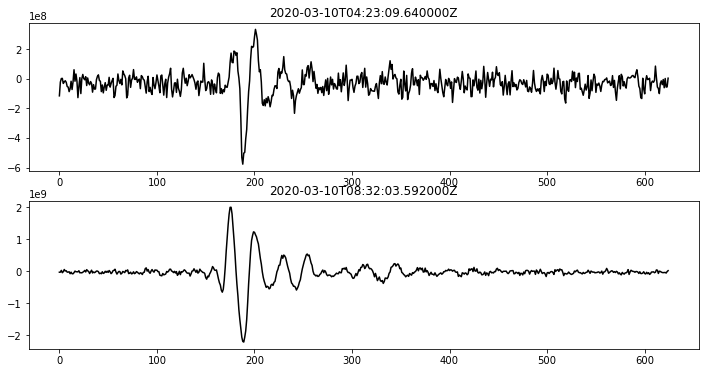

****************************************************************************************************
2


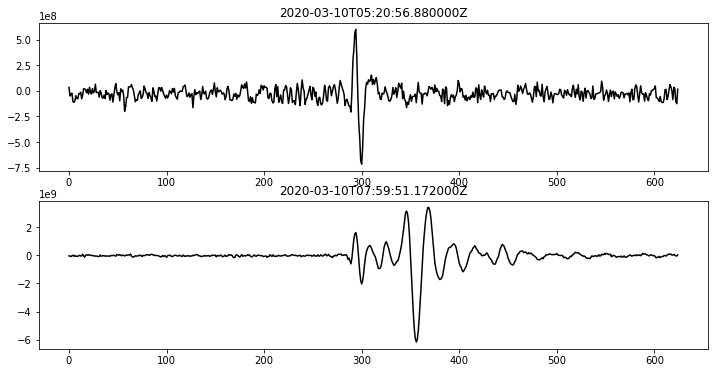

****************************************************************************************************
2


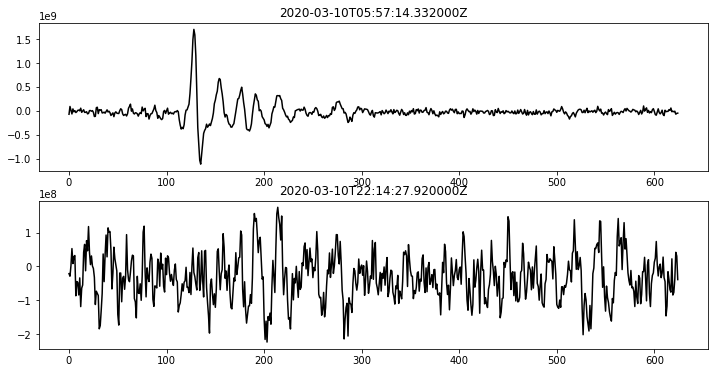

****************************************************************************************************
2


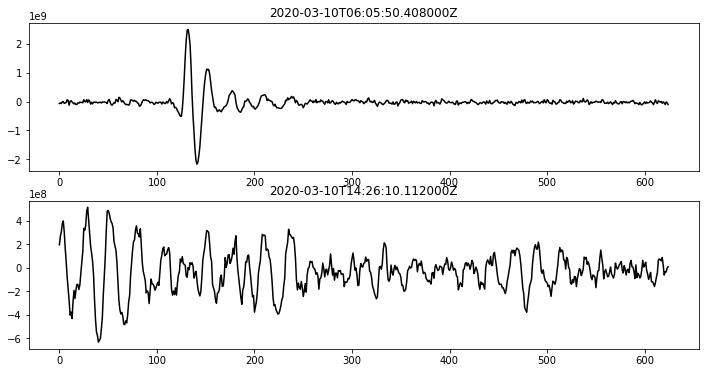

****************************************************************************************************
2


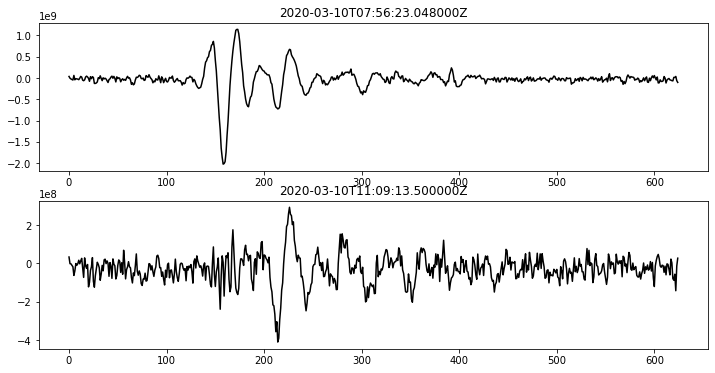

****************************************************************************************************
2


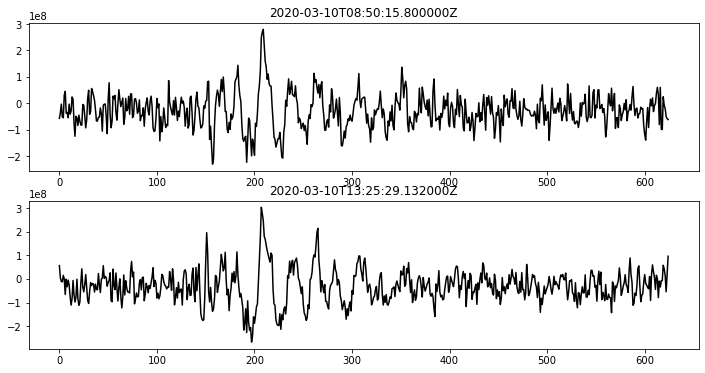

****************************************************************************************************
2


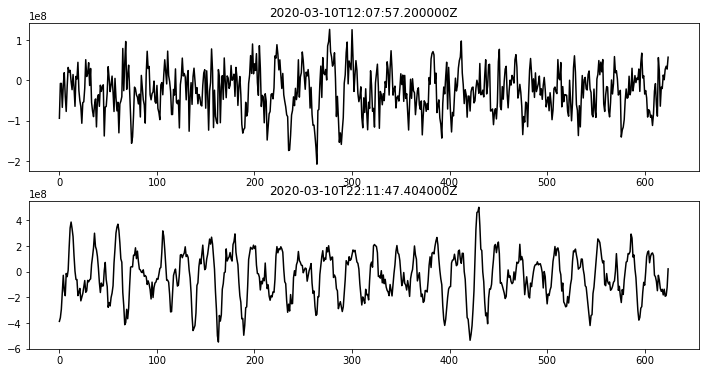

****************************************************************************************************
2


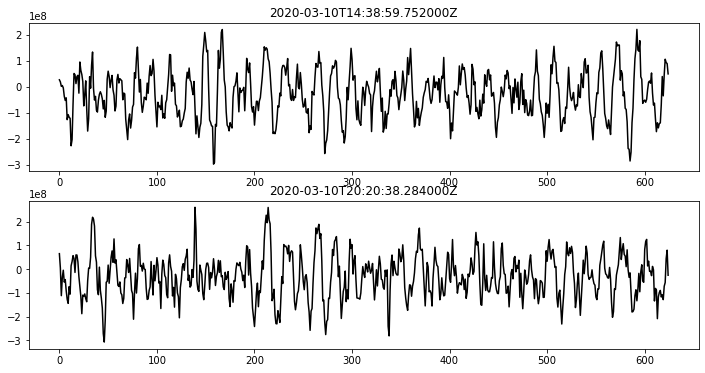

****************************************************************************************************
2


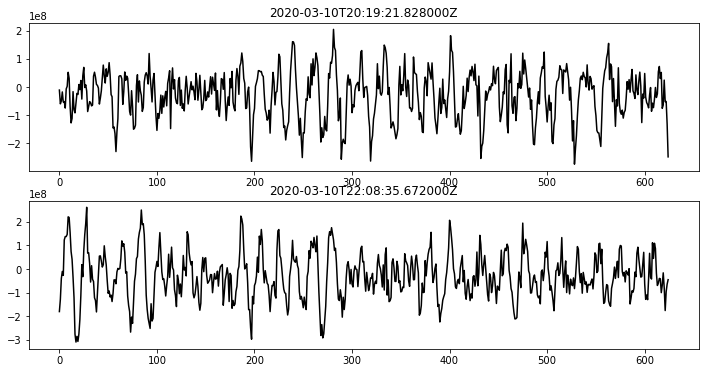

****************************************************************************************************
2


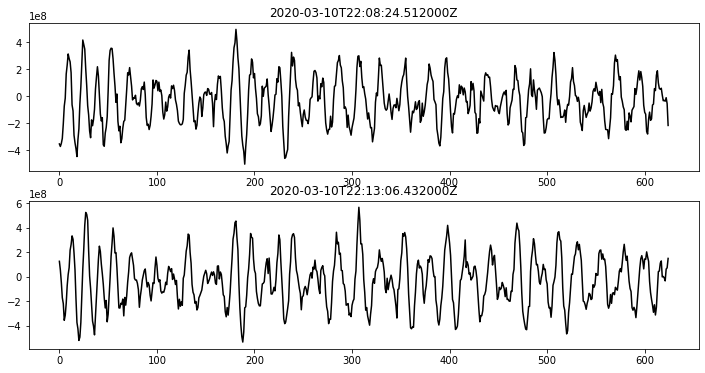

****************************************************************************************************
2


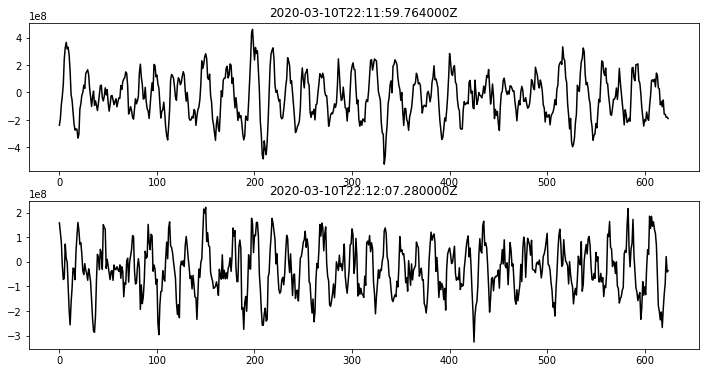

****************************************************************************************************


In [279]:
# Initialize graph
print("Building the graph...")
nrow = len(dfref)
print(nrow)
g = Graph(nrow)
for i, row in df.iterrows():
    id1 = row["win_id_1"]
    id2 = row["win_id_2"]
    g.addEdge(id1, id2)
    
print("Getting connected components...")
procs = time.time()
cc = g.connectedComponents()
proce = time.time()
print("Time to get connected components: %f s." % (proce - procs))
cc = sorted(cc, key=lambda x: len(x), reverse=True) # Sort by decreasing # of links
tstart = starttime + sublen_samp/fs
print(tstart)

plt.close("all")
for group in cc:
    ndet = len(group)
    print(ndet)
    
    if ndet > 40:
        continue
    
    
    if ndet > 1:
    
        N = ndet
        fig, axs = plt.subplots(N, 1, figsize=(12,3*N))
        for i, wid in enumerate(group[:N]):
            lb = dfref.loc[dfref["window_id"] == wid]["lower_bound"].values[0]
            ub = dfref.loc[dfref["window_id"] == wid]["upper_bound"].values[0]
            wstart = tstart + lb/fs
            wend = tstart + ub/fs
            detdata = trace.slice(starttime=wstart-1.0, endtime=wend+1.0).data
            axs[i].plot(detdata, "k")
            axs[i].set_title("%s" % wstart)
        plt.show()
        plt.close()
    
    if ndet == 1:
        
        wid = group[0]
        print("ID: %d" % wid)
        row = dfref.loc[dfref["window_id"] == wid]
        if len(row) > 0:
            lb = dfref.loc[dfref["window_id"] == wid]["lower_bound"].values[0]
            ub = dfref.loc[dfref["window_id"] == wid]["upper_bound"].values[0]
            wstart = tstart + lb/fs
            wend = tstart + ub/fs
            detdata = trace.slice(starttime=wstart-1.0, endtime=wend+1.0).data
            plt.plot(detdata, "k")
            plt.set_title("%s" % wstart)
        else:
            print("Window ID not found in dfref?")
        
        
    print("%s" % "*"*100)

In [272]:
len(df)

3023